In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#=========================================================================================================
# Load dataset and check their dimensions
#=========================================================================================================

# Input and output dimensions
num_samples = 8000  # Number of samples for tarining dataset
num_variables = 10  # Total variables in the output data
num_timepoints = 13  # Number of time points

# Hyperparameters
num_epochs = 200
learning_rate = 1e-5

# Load the CSV files
input_path = 'train_input_data.csv'
output_path = 'train_output_data.csv'
patient_id_path = 'train_patient_ids.csv'

df_input = pd.read_csv(input_path, header=None)
df_output = pd.read_csv(output_path, header=None)
df_patient_ids = pd.read_csv(patient_id_path, header=None)

# Convert DataFrames to NumPy arrays
data_input = df_input.to_numpy()
data_output = df_output.to_numpy()
patient_ids = df_patient_ids.to_numpy().flatten()

num_clusters = data_input.shape[0] // num_samples

# Ensure data has correct shape
if data_input.shape != (num_samples * num_clusters, num_timepoints):
    raise ValueError(f"Input data must have {num_samples * num_clusters} rows and {num_timepoints} columns")

if data_output.shape != (num_samples * num_variables, num_timepoints):
    raise ValueError(f"Output data must have {num_samples * num_variables} rows and {num_timepoints} columns")

if patient_ids.shape != (num_samples,):
    raise ValueError(f"Patient IDs must have {num_samples} entries")

# Reshape data
reshaped_data_input = data_input.reshape(num_samples, num_clusters, num_timepoints)
reshaped_data_output = data_output.reshape(num_samples, num_variables, num_timepoints)

# Convert data to PyTorch tensors
input_data = torch.tensor(reshaped_data_input, dtype=torch.float32)
output_data = torch.tensor(reshaped_data_output, dtype=torch.float32)
patient_ids_tensor = torch.tensor(patient_ids, dtype=torch.long)

#=========================================================================================================
# Prepare for time point-wise training
#=========================================================================================================

# Reshape input and output data to treat each time point as a separate sample
input_data_timepointwise = input_data.transpose(1, 2).reshape(-1, num_clusters)
output_data_timepointwise = output_data.transpose(1, 2).reshape(-1, num_variables)
patient_ids_timepointwise = patient_ids_tensor.repeat_interleave(num_timepoints)


In [2]:
# Load testing patients data

num_samples_test = 4000 # Number of samples for test dataset

# Load the CSV files
input_path_np = 'test_input_data.csv'  # sampled randomly from the clusters
output_path_np = 'test_output_data.csv'  # sampled randomly from the clusters
patient_id_path_np = 'test_patient_ids.csv'  # Path to the CSV file containing patient IDs

df_input_np = pd.read_csv(input_path_np, header=None)
df_output_np = pd.read_csv(output_path_np, header=None)
df_patient_ids_np = pd.read_csv(patient_id_path_np, header=None)

# Convert DataFrames to NumPy arrays
data_input_np = df_input_np.to_numpy()
data_output_np = df_output_np.to_numpy()
patient_ids_np = df_patient_ids_np.to_numpy().flatten()

# Ensure the input data has {num_samples_test * num_clusters} rows and {num_timepoints} columns
if data_input_np.shape != (num_samples_test * num_clusters, num_timepoints):
    raise ValueError(f"The input data must have {num_samples_test * num_clusters} rows and {num_timepoints} columns")

# Ensure the output data has {num_samples_test * num_variables} rows and {num_timepoints} columns
if data_output_np.shape != (num_samples_test * num_variables, num_timepoints):
    raise ValueError(f"The output data must have {num_samples_test * num_variables} rows and {num_timepoints} columns")

# Ensure the patient IDs data has {num_samples_test} entries
if patient_ids_np.shape != (num_samples_test,):
    raise ValueError(f"The patient IDs must have {num_samples_test} entries")

# Reshape the data to desired size
reshaped_data_input_np = data_input_np.reshape(num_samples_test, num_clusters, num_timepoints)
reshaped_data_output_np = data_output_np.reshape(num_samples_test, num_variables, num_timepoints)

# Convert the reshaped data to a PyTorch tensor
input_data_np = torch.tensor(reshaped_data_input_np, dtype=torch.float32)
output_data_np = torch.tensor(reshaped_data_output_np, dtype=torch.float32)
patient_ids_tensor_np = torch.tensor(patient_ids_np, dtype=torch.long)

# Print the shape of the tensors to verify
print(f"Input data shape: {input_data_np.shape}")
print(f"Output data shape: {output_data_np.shape}")
print(f"Patient IDs shape: {patient_ids_tensor_np.shape}")

#=========================================================================================================
# Prepare for time point-wise for testing
#=========================================================================================================

# Reshape input and output data to treat each time point as a separate sample
input_data_np_timepointwise = input_data_np.transpose(1, 2).reshape(-1, num_clusters)
output_data_np_timepointwise = output_data_np.transpose(1, 2).reshape(-1, num_variables)
patient_ids_np_timepointwise = patient_ids_tensor_np.repeat_interleave(num_timepoints)


Input data shape: torch.Size([4000, 15, 13])
Output data shape: torch.Size([4000, 10, 13])
Patient IDs shape: torch.Size([4000])


In [3]:

# Create datasets and dataloaders

train_dataset_timepointwise = TensorDataset(input_data_timepointwise, output_data_timepointwise, patient_ids_timepointwise)
test_dataset_timepointwise = TensorDataset(input_data_np_timepointwise, output_data_np_timepointwise, patient_ids_np_timepointwise)
train_loader = DataLoader(train_dataset_timepointwise, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset_timepointwise, batch_size=100, shuffle=False)


Epoch 1/200, Train Loss: 47.3599, Test Loss: 56.8006
Epoch 2/200, Train Loss: 38.4781, Test Loss: 41.5445
Epoch 3/200, Train Loss: 28.8801, Test Loss: 30.5274
Epoch 4/200, Train Loss: 25.5364, Test Loss: 27.5047
Epoch 5/200, Train Loss: 24.6680, Test Loss: 26.4844
Epoch 6/200, Train Loss: 24.1235, Test Loss: 25.6648
Epoch 7/200, Train Loss: 23.1711, Test Loss: 24.6802
Epoch 8/200, Train Loss: 22.0807, Test Loss: 23.4358
Epoch 9/200, Train Loss: 20.9465, Test Loss: 22.1735
Epoch 10/200, Train Loss: 19.9663, Test Loss: 21.1456
Epoch 11/200, Train Loss: 18.8087, Test Loss: 19.7404
Epoch 12/200, Train Loss: 17.9705, Test Loss: 18.9896
Epoch 13/200, Train Loss: 17.3676, Test Loss: 18.0619
Epoch 14/200, Train Loss: 16.9250, Test Loss: 17.2848
Epoch 15/200, Train Loss: 16.5815, Test Loss: 16.9680
Epoch 16/200, Train Loss: 16.2704, Test Loss: 16.6530
Epoch 17/200, Train Loss: 16.1222, Test Loss: 16.3812
Epoch 18/200, Train Loss: 16.0078, Test Loss: 16.1093
Epoch 19/200, Train Loss: 15.7916, Te

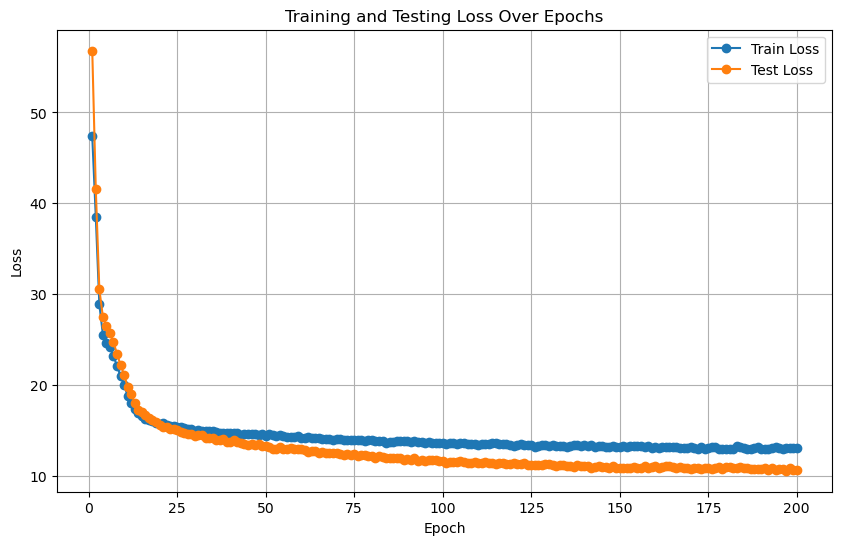

In [8]:
#=========================================================================================================
# Define the feedforward neural network
#=========================================================================================================
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model, loss function, and optimizer
model = FeedforwardNN(num_clusters, num_variables)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#=========================================================================================================
# Train the model
#=========================================================================================================
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets, _ in train_loader:  # Patient IDs not used in this simple model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Testing phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#=========================================================================================================
# Plot training and testing loss
#=========================================================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [9]:
import csv

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Placeholder for reconstructed outputs (which will be used as input for the reverse VAE)
all_reconstructed_outputs = []

# Loop over each sample in the input data
with torch.no_grad():
    for i in range(num_samples):
        input_sample = input_data[i].to(device)  # Shape: (num_clusters, num_timepoints)
        
        # Initialize an empty list to store reconstructed outputs for each timepoint
        reconstructed_output_for_sample = []
        
        # Loop over each timepoint to get reconstructed output for each timepoint
        for t in range(num_timepoints):
            input_timepoint = input_sample[:, t].unsqueeze(0)  # Shape: (1, num_clusters)
            
            # Get the reconstructed output from the VAE
            recon = model(input_timepoint)
            
            # Append the reconstructed output to the list for this sample
            reconstructed_output_for_sample.append(recon.squeeze(0).cpu().numpy())  # Shape: (num_variables,)

        # Convert list of reconstructed outputs for this sample into an array and reshape to (num_variables, num_timepoints)
        reconstructed_output_for_sample = np.array(reconstructed_output_for_sample).T  # Shape: (num_variables, num_timepoints)
        
        # Append this sample's reconstructed output to the overall list
        all_reconstructed_outputs.append(reconstructed_output_for_sample)

# Convert the list of all reconstructed outputs to a numpy array with shape (num_samples, num_variables, num_timepoints)
all_reconstructed_outputs = np.array(all_reconstructed_outputs)

# Reshape to (num_samples * num_variables, num_timepoints) to match the expected format
all_reconstructed_outputs = all_reconstructed_outputs.reshape(num_samples * num_variables, num_timepoints)

# Save the reconstructed outputs to a CSV file
output_filename = 'vae_reconstructed_outputs.csv'
with open(output_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(all_reconstructed_outputs)

print(f'Reconstructed outputs saved to {output_filename}')


Reconstructed outputs saved to vae_reconstructed_outputs.csv


In [10]:
import csv

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Placeholder for reconstructed outputs (which will be used as input for the reverse VAE)
all_reconstructed_outputs = []

# Loop over each sample in the input data
with torch.no_grad():
    for i in range(num_samples_test):
        input_sample = input_data_np[i].to(device)  # Shape: (num_clusters, num_timepoints)
        
        # Initialize an empty list to store reconstructed outputs for each timepoint
        reconstructed_output_for_sample = []
        
        # Loop over each timepoint to get reconstructed output for each timepoint
        for t in range(num_timepoints):
            input_timepoint = input_sample[:, t].unsqueeze(0)  # Shape: (1, num_clusters)
            
            # Get the reconstructed output from the VAE
            recon = model(input_timepoint)
            
            # Append the reconstructed output to the list for this sample
            reconstructed_output_for_sample.append(recon.squeeze(0).cpu().numpy())  # Shape: (num_variables,)

        # Convert list of reconstructed outputs for this sample into an array and reshape to (num_variables, num_timepoints)
        reconstructed_output_for_sample = np.array(reconstructed_output_for_sample).T  # Shape: (num_variables, num_timepoints)
        
        # Append this sample's reconstructed output to the overall list
        all_reconstructed_outputs.append(reconstructed_output_for_sample)

# Convert the list of all reconstructed outputs to a numpy array with shape (num_samples, num_variables, num_timepoints)
all_reconstructed_outputs = np.array(all_reconstructed_outputs)

# Reshape to (num_samples * num_variables, num_timepoints) to match the expected format
all_reconstructed_outputs = all_reconstructed_outputs.reshape(num_samples_test * num_variables, num_timepoints)

# Save the reconstructed outputs to a CSV file
output_filename = 'vae_reconstructed_outputs_test.csv'
with open(output_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(all_reconstructed_outputs)

print(f'Reconstructed outputs for test set saved to {output_filename}')


Reconstructed outputs for test set saved to vae_reconstructed_outputs_test.csv


In [11]:
# Load the mean data from CSV
mean_data_path = 'input_data_mean.csv'
df_mean_data = pd.read_csv(mean_data_path)

# Load patient IDs from the CSV file (they are in a single row)
patient_id_path = 'train_patient_ids.csv'
df_patient_ids = pd.read_csv(patient_id_path, header=None)

# Convert the row into a list
patient_ids_list = df_patient_ids.iloc[0].tolist()  # Extracting the first row and converting to a list

# Prepare a list to collect the filtered data
filtered_patient_cluster_data = []

# Loop over each patient ID and filter the data
for patient in patient_ids_list:
    # Select rows for the current patient
    patient_data = df_mean_data[df_mean_data.iloc[:, 0] == f'Patient_{patient}']  # first column is patient info
    
    # Extract mean values for all clusters and timepoints (ignoring patient and cluster columns)
    mean_values = patient_data.iloc[:, 2:].values  # Adjust to capture only timepoint data
    
    filtered_patient_cluster_data.append(mean_values)

# Convert the list to a 3D numpy array
filtered_patient_cluster_data = np.array(filtered_patient_cluster_data)

# Reshape to (num_samples * num_clusters, num_timepoints) format
reshaped_data = filtered_patient_cluster_data.reshape(filtered_patient_cluster_data.shape[0] * filtered_patient_cluster_data.shape[1], filtered_patient_cluster_data.shape[2])

# Save the reshaped data to a CSV file
output_filename = 'sampled_mean_cluster_data.csv'
np.savetxt(output_filename, reshaped_data, delimiter=',')
print(f'Mean cluster data saved to {output_filename}')


Mean cluster data saved to sampled_mean_cluster_data.csv


In [12]:
# Load the mean data from CSV
mean_data_path = 'input_data_mean.csv'
df_mean_data = pd.read_csv(mean_data_path)

# Load patient IDs from the CSV file (they are in a single row)
patient_id_path = 'test_patient_ids.csv'
df_patient_ids = pd.read_csv(patient_id_path, header=None)

# Convert the row into a list
patient_ids_list = df_patient_ids.iloc[0].tolist()  # Extracting the first row and converting to a list

# Prepare a list to collect the filtered data
filtered_patient_cluster_data = []

# Loop over each patient ID and filter the data
for patient in patient_ids_list:
    # Select rows for the current patient
    patient_data = df_mean_data[df_mean_data.iloc[:, 0] == f'Patient_{patient}']  # first column is patient info
    
    # Extract mean values for all clusters and timepoints (ignoring patient and cluster columns)
    mean_values = patient_data.iloc[:, 2:].values  # Adjust to capture only timepoint data
    
    filtered_patient_cluster_data.append(mean_values)

# Convert the list to a 3D numpy array
filtered_patient_cluster_data = np.array(filtered_patient_cluster_data)

# Reshape to (num_samples * num_clusters, num_timepoints) format
reshaped_data = filtered_patient_cluster_data.reshape(filtered_patient_cluster_data.shape[0] * filtered_patient_cluster_data.shape[1], filtered_patient_cluster_data.shape[2])

# Save the reshaped data to a CSV file
output_filename = 'sampled_mean_cluster_data_test.csv'
np.savetxt(output_filename, reshaped_data, delimiter=',')
print(f'Mean cluster data for test set saved to {output_filename}')


Mean cluster data for test set saved to sampled_mean_cluster_data_test.csv


In [13]:
# =====================================================================================================
# Data preparation for Reverse VAE model
# =====================================================================================================

# Define the paths for input and output data (with 'reverse' context)
input_path_reverse = 'vae_reconstructed_outputs.csv'  # Input path for VAE reconstructed outputs
output_path_reverse = 'sampled_mean_cluster_data.csv'  # Output path for sampled mean cluster data

# Load the CSV files
df_input_reverse = pd.read_csv(input_path_reverse, header=None)
df_output_reverse = pd.read_csv(output_path_reverse, header=None)

# Convert DataFrames to NumPy arrays
input_array_reverse = df_input_reverse.to_numpy()
output_array_reverse = df_output_reverse.to_numpy()

# Reshape data for Reverse VAE model
reshaped_input_reverse = input_array_reverse.reshape(num_samples, num_variables, num_timepoints)
reshaped_output_reverse = output_array_reverse.reshape(num_samples, num_clusters, num_timepoints)

# Convert data to PyTorch tensors
input_tensor_reverse = torch.tensor(reshaped_input_reverse, dtype=torch.float32)
output_tensor_reverse = torch.tensor(reshaped_output_reverse, dtype=torch.float32)

#=========================================================================================================
# Prepare for time point-wise training (reverse)
#=========================================================================================================

# Reshape input and output data to treat each time point as a separate sample
input_data_timepointwise_reverse = input_tensor_reverse.transpose(1, 2).reshape(-1, num_variables)
output_data_timepointwise_reverse = output_tensor_reverse.transpose(1, 2).reshape(-1, num_clusters)


input_data_reverse = input_data_timepointwise_reverse  # (Mathematical model variables)
output_data_reverse = output_data_timepointwise_reverse  # (Gene expression values)



In [14]:
# =====================================================================================================
# Data preparation for Reverse VAE model
# =====================================================================================================

# Define the paths for input and output data (with 'reverse' context)
input_path_reverse_test = 'vae_reconstructed_outputs_test.csv'  # Input path for VAE reconstructed outputs
output_path_reverse_test = 'sampled_mean_cluster_data_test.csv'  # Output path for sampled mean cluster data

# Load the CSV files
df_input_reverse_test = pd.read_csv(input_path_reverse_test, header=None)
df_output_reverse_test = pd.read_csv(output_path_reverse_test, header=None)

# Convert DataFrames to NumPy arrays
input_array_reverse_test = df_input_reverse_test.to_numpy()
output_array_reverse_test = df_output_reverse_test.to_numpy()

# Reshape data for Reverse VAE model
reshaped_input_reverse_test = input_array_reverse_test.reshape(num_samples_test, num_variables, num_timepoints)
reshaped_output_reverse_test = output_array_reverse_test.reshape(num_samples_test, num_clusters, num_timepoints)

# Convert data to PyTorch tensors
input_tensor_reverse_test = torch.tensor(reshaped_input_reverse_test, dtype=torch.float32)
output_tensor_reverse_test = torch.tensor(reshaped_output_reverse_test, dtype=torch.float32)

#=========================================================================================================
# Prepare for time point-wise training (reverse)
#=========================================================================================================

# Reshape input and output data to treat each time point as a separate sample
input_data_timepointwise_reverse_test = input_tensor_reverse_test.transpose(1, 2).reshape(-1, num_variables)
output_data_timepointwise_reverse_test = output_tensor_reverse_test.transpose(1, 2).reshape(-1, num_clusters)


input_data_reverse_test = input_data_timepointwise_reverse_test  # (Mathematical model variables)
output_data_reverse_test = output_data_timepointwise_reverse_test # (Gene expression values)



In [15]:
# Create datasets and dataloaders for reverse mapping
train_dataset_reverse = TensorDataset(input_data_reverse, output_data_reverse, patient_ids_timepointwise)
test_dataset_reverse = TensorDataset(input_data_reverse_test, output_data_reverse_test, patient_ids_np_timepointwise)

# Create DataLoaders for the training and testing datasets
train_loader_reverse = DataLoader(train_dataset_reverse, batch_size=100, shuffle=True)
test_loader_reverse = DataLoader(test_dataset_reverse, batch_size=100, shuffle=False)

Epoch 1/200, Train Loss: 1.5895, Test Loss: 0.8671
Epoch 2/200, Train Loss: 0.9502, Test Loss: 0.5724
Epoch 3/200, Train Loss: 0.7440, Test Loss: 0.3887
Epoch 4/200, Train Loss: 0.6131, Test Loss: 0.3006
Epoch 5/200, Train Loss: 0.5535, Test Loss: 0.2734
Epoch 6/200, Train Loss: 0.5173, Test Loss: 0.2516
Epoch 7/200, Train Loss: 0.4928, Test Loss: 0.2332
Epoch 8/200, Train Loss: 0.4761, Test Loss: 0.2257
Epoch 9/200, Train Loss: 0.4616, Test Loss: 0.2135
Epoch 10/200, Train Loss: 0.4526, Test Loss: 0.2087
Epoch 11/200, Train Loss: 0.4437, Test Loss: 0.2044
Epoch 12/200, Train Loss: 0.4399, Test Loss: 0.1996
Epoch 13/200, Train Loss: 0.4354, Test Loss: 0.1968
Epoch 14/200, Train Loss: 0.4307, Test Loss: 0.1959
Epoch 15/200, Train Loss: 0.4271, Test Loss: 0.1891
Epoch 16/200, Train Loss: 0.4248, Test Loss: 0.1872
Epoch 17/200, Train Loss: 0.4224, Test Loss: 0.1822
Epoch 18/200, Train Loss: 0.4207, Test Loss: 0.1841
Epoch 19/200, Train Loss: 0.4193, Test Loss: 0.1810
Epoch 20/200, Train L

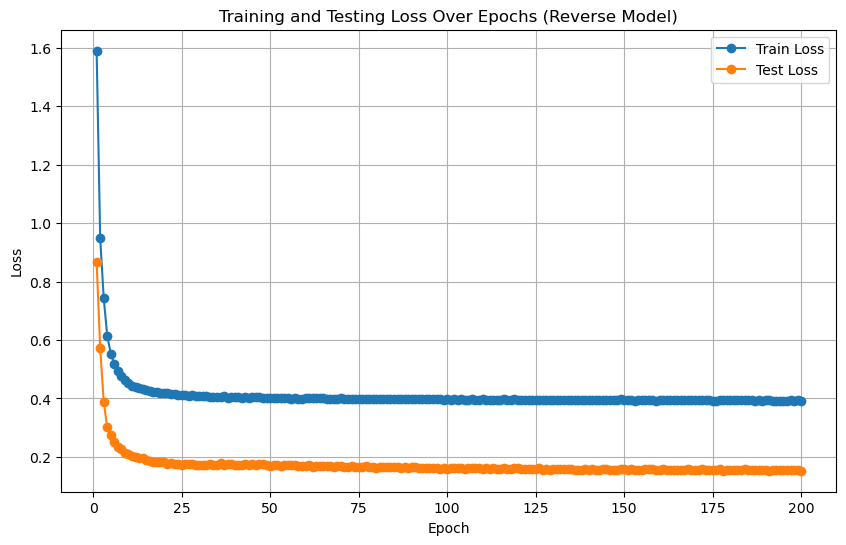

In [16]:
#=========================================================================================================
# Define the feedforward neural network for reverse
#=========================================================================================================
class FeedforwardNNreverse(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNNreverse, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize reverse model, loss function, and optimizer
reverse_model = FeedforwardNNreverse(num_variables, num_clusters).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(reverse_model.parameters(), lr=learning_rate)

#=========================================================================================================
# Train the reverse model
#=========================================================================================================
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    reverse_model.train()
    train_loss = 0.0
    for inputs, targets, _ in train_loader_reverse:  # Patient IDs not used
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = reverse_model(inputs)  # Use reverse model
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader_reverse.dataset)
    train_losses.append(train_loss)
    
    # Testing phase
    reverse_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets, _ in test_loader_reverse:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = reverse_model(inputs)  # Use reverse model
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss /= len(test_loader_reverse.dataset)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#=========================================================================================================
# Plot training and testing loss
#=========================================================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs (Reverse Model)')
plt.legend()
plt.grid()
plt.show()


In [17]:
# =========================================================================================================
# Extract standard deviation data for each patient, cluster, and timepoint
#==========================================================================================================

# Load the gene standard deviations data 
std_data_path = 'input_data_std.csv'
df_std_data = pd.read_csv(std_data_path)

# Initialize the tensor for gene variances per patient, cluster, and timepoint
gene_variances_per_cluster_timepoint = torch.zeros(num_samples, num_clusters, num_timepoints)

# Populate the tensor using the loaded std data from CSV
for patient_idx in range(num_samples):
    # Get the patient ID for the current sample
    patient_id = patient_ids[patient_idx]  # This is the patient index for the current sample
    patient_label = f"Patient_{patient_id}"  # Construct the patient label
    for cluster_idx in range(num_clusters):
        # Construct labels to filter std data for the specific patient and cluster
        cluster_label = f"Cluster_{cluster_idx + 1}"
        
        # Filter the standard deviation data for the current patient and cluster
        filtered_data = df_std_data[(df_std_data['Patient'] == patient_label) & (df_std_data['Cluster'] == cluster_label)]

        # Extract timepoint values
        timepoint_values = filtered_data.iloc[0, 2:].values  # first two columns are 'Patient' and 'Cluster'
        timepoint_values = pd.to_numeric(timepoint_values)
        
        # Assign to tensor
        gene_variances_per_cluster_timepoint[patient_idx, cluster_idx, :] = torch.tensor(timepoint_values, dtype=torch.float32)

# Move tensor to GPU if available
gene_variances_per_cluster_timepoint = gene_variances_per_cluster_timepoint.to('cuda' if torch.cuda.is_available() else 'cpu')

# Print the shape of the tensors to verify
print(f"Gene STD data shape: {gene_variances_per_cluster_timepoint.shape}")

# Timepoint wise shape
gene_std_data_timepointwise = gene_variances_per_cluster_timepoint.transpose(1, 2).reshape(-1, num_clusters)

# Print the shape of the tensors to verify
print(f"Gene STD data shape timepointwise: {gene_std_data_timepointwise.shape}")

Gene STD data shape: torch.Size([8000, 15, 13])
Gene STD data shape timepointwise: torch.Size([104000, 15])


In [18]:
def original_vs_predicted(model, mean_data, output_data_np, patient_id, patient_ids_tensor_np, timepoint):
    """
    Plot the original data vs. predicted data for a specific patient and timepoint.

    Parameters:
    - model: Trained PyTorch model.
    - mean_data (Tensor): Mean data for input clusters at the given timepoint.
    - output_data_np (Tensor): Tensor containing the true output data for all patients.
    - patient_id (int): ID of the patient to evaluate.
    - patient_ids_tensor_np (Tensor): Tensor of patient IDs corresponding to the output data.
    - timepoint (int): The specific timepoint for evaluation (Python index).

    Returns:
    - None: Displays the plot comparing original and predicted data.
    """
    # Ensure mean data has correct shape
    mean_data = mean_data.unsqueeze(0)  # Add batch dimension: Shape [1, num_clusters]

    # Get true data for the patient and timepoint
    patient_indices = (patient_ids_tensor_np == patient_id).nonzero(as_tuple=True)[0]
    if patient_indices.numel() == 0:
        raise ValueError(f"Patient ID {patient_id} not found in the test data.")
    
    # Get the true output for the specified patient and timepoint
    true_output = output_data_np[patient_indices[0], :, timepoint].squeeze(0)  # Shape [num_variables]

    # Predict using the model
    model.eval()
    with torch.no_grad():
        predicted_output = model(mean_data).squeeze(0)  # Shape [num_variables]

    # Convert to NumPy for plotting
    true_output_np = true_output.numpy().flatten()
    predicted_output_np = predicted_output.numpy().flatten()

    return mean_data, predicted_output_np, true_output_np

In [19]:
# =========================================================================================================
#  Timepoint names and variable names
# =========================================================================================================

timepoint_names = [ 'Before Surgery', '5 Minutes', '30 Minutes', '60 Minutes', 
    '120 Minutes', '1 Day', '2 Days', '3 Days', 
    '4 Days', '10 Days', '3 Months', '6 Months', '1 Year' ]


variable_names = ['TNF', 'JAK', 'STAT3', 'SOCS3', 'ECM', 
                  'IE', 'GF', 'Q', 'P', 'R']


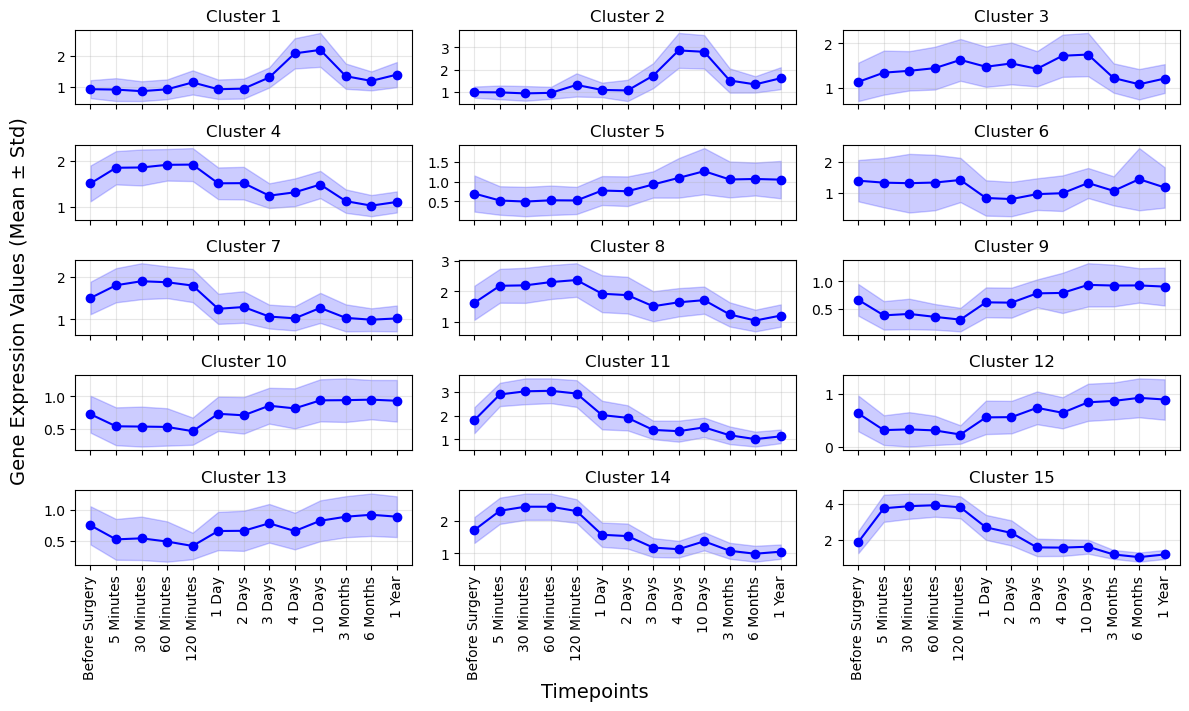

In [20]:
# ================================================================================================
# Plot the mean and standard deviation of gene values: original data with filled regions
# ================================================================================================

# Construct patient and cluster labels to filter mean and std data for the specific patient and timepoint
patient_id = 10
patient_label = f"Patient_{patient_id}"

# Load mean data
mean_data_path = 'input_data_mean.csv'
df_mean_data = pd.read_csv(mean_data_path)

# Load standard deviation data
std_data_path = 'input_data_std.csv'
df_std_data = pd.read_csv(std_data_path)

# Define the timepoint column name based on the timepoint index
num_timepoints = 13
timepoint_values = np.arange(1, num_timepoints + 1)

# Filter the data to get only rows that match the specified patient
patient_mean_data = df_mean_data[df_mean_data['Patient'] == patient_label]
patient_std_data = df_std_data[df_std_data['Patient'] == patient_label]

# Extract mean and std data vectors for the specified timepoints across all clusters
mean_data = patient_mean_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)
std_data = patient_std_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)

# Create a 4 by 4 subplot grid
fig, axes = plt.subplots(5, 3, figsize=(12, 7), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot data for each cluster
for idx in range(mean_data.shape[0]):  # Loop through clusters
    # Plot mean curve
    axes[idx].plot(timepoint_names, mean_data[idx, :], '-o', label=f"Cluster {idx + 1}", color='blue')
    
    # Add shaded region for std deviation
    axes[idx].fill_between(
        timepoint_names,
        mean_data[idx, :] - std_data[idx, :],
        mean_data[idx, :] + std_data[idx, :],
        color='blue',
        alpha=0.2
    )
    
    # Customize subplot
    axes[idx].set_xticks(timepoint_names)  # Set x-axis ticks with the timepoint names 
    axes[idx].set_xticklabels(timepoint_names, rotation=90)  # Rotate tick labels
    axes[idx].set_title(f"Cluster {idx + 1}", fontsize=12)
    axes[idx].grid(alpha=0.3)
    if idx == 6:  # Label only the first subplot in each row
        axes[idx].set_ylabel("Gene Expression Values (Mean ± Std) \n", fontsize=14)

# Set the x-axis labels across all subplots
fig.text(0.5, -0.004, 'Timepoints', ha='center', fontsize=14)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save figure
fig.savefig(f"Patient_{patient_id}_gene_expression.png", dpi=600, bbox_inches='tight')

plt.show()


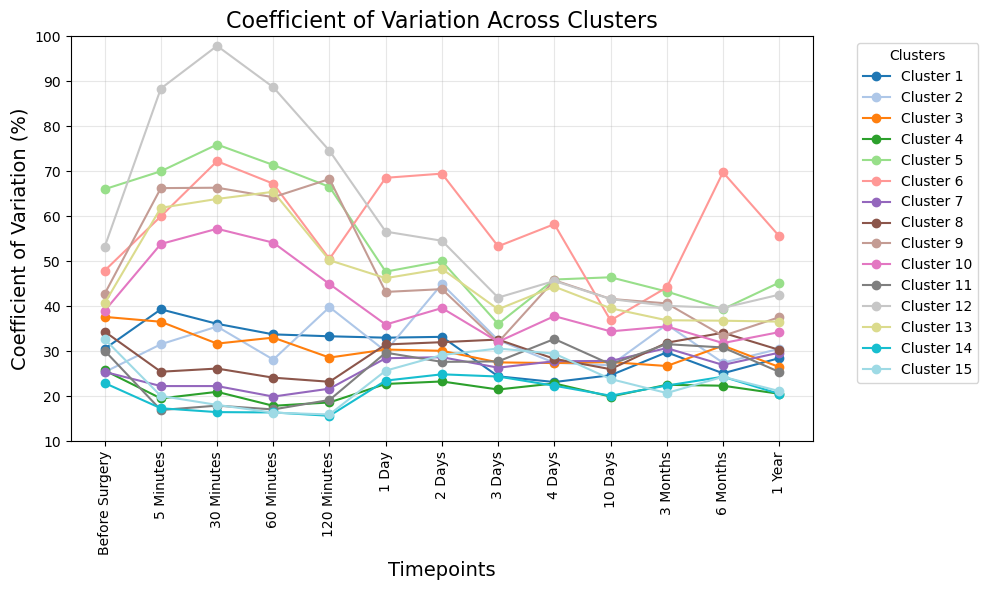

In [21]:
# ================================================================================================
# Compute Coefficient of Variation (CV) and compare across clusters
# ================================================================================================

# Compute CV for each cluster at each timepoint
cv_data = (std_data / mean_data) * 100  # Shape: (num_clusters, num_timepoints)

# Generate a distinct color palette using Matplotlib's colormap
num_clusters = cv_data.shape[0]
colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))  # Tab20 colormap

# Plot CV for each cluster
fig, ax = plt.subplots(figsize=(10, 6))

for idx in range(num_clusters):  # Loop through clusters
    ax.plot(
        timepoint_names,
        cv_data[idx, :],
        '-o',
        label=f"Cluster {idx + 1}",
        color=colors[idx]
    )

# Customize plot
ax.set_title("Coefficient of Variation Across Clusters", fontsize=16)
ax.set_xlabel("Timepoints", fontsize=14)
ax.set_ylabel("Coefficient of Variation (%)", fontsize=14)
ax.grid(alpha=0.3)
ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Set y-axis limits
ax.set_ylim(10, 100)

# Rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


In [22]:
def liver_regen_model(t, y):
    # Parameters
    M = 5.8

    # TNF
    ktnf = 1.5
    kaptnf = 0.9

    # JAK
    vjak = 2e4
    kmjak = 1e4
    kapjak = 0.4

    # STAT3
    kprost3 = 2
    vst3 = 750
    kmst3 = 0.4
    kapst3 = 0.1

    # SOCS3
    vsoc = 2.4e4
    kmsoc = 7e-4
    kisoc = 15e-3
    kapsoc = 0.4

    # IE
    vie = 2.5e2
    kmie = 18
    kapie = 5

    # GF
    kup = 6e-2
    kgf = 1.125e-1
    kapgf = 0.23

    # ECM
    kapecm = 33
    kdeg = 7
    kecm = kapecm + kdeg

    # Steady-state production rates
    prtnf = vjak / (kmjak + 1) + kaptnf - ktnf * M
    prst3 = -vst3 * (kprost3 ** 2) / (kprost3 ** 2 + kmst3 * (1 + 1 / kisoc)) + vie / (1 + kmie) + vsoc / (1 + kmsoc) + kapst3
    prsoc = -vsoc / (1 + kmsoc) + kapsoc
    prgf = kup + kapgf - kgf * M
    prie = -vie / (1 + kmie) + kapie
    prjak = -vjak / (kmjak + 1) + kapjak

    # Cell cycle
    kq = 7e-3
    kr = 5.4e-2
    kp = 4.4e-3
    kprol = 2e-2

    kreq = 1e-1
    thetar = 8
    betar = 3

    # Apoptosis
    kapop = 1e-1 / 24
    thetaa = 0.15
    betaa = 0.075

    # Variables
    TNF, JAK, ST3, SOCS3, ECM, IE, GF, Q, P, R = y

    dy = np.zeros(10)
    sum_cells = Q + P + R
    sigmoid_r = 0.5 * (1 + np.tanh((thetar - GF) / betar))
    sigmoid_a = 0.5 * (1 + np.tanh((thetaa - sum_cells) / betaa))

    dy[0] = ktnf * M / sum_cells - vjak * TNF / (kmjak + TNF) - kaptnf * TNF + prtnf
    dy[1] = vjak * TNF / (kmjak + TNF) - kapjak * JAK + prjak
    dy[2] = vst3 * (kprost3 ** 2) * JAK / (kprost3 ** 2 + kmst3 * (1 + SOCS3 / kisoc)) \
            - vie * ST3 / (ST3 + kmie) - vsoc * ST3 / (ST3 + kmsoc) - kapst3 * ST3 + prst3
    dy[3] = vsoc * ST3 / (ST3 + kmsoc) - kapsoc * SOCS3 + prsoc
    dy[4] = -kdeg * TNF * ECM - kapecm * ECM + kecm
    dy[5] = vie * ST3 / (ST3 + kmie) - kapie * IE + prie
    dy[6] = kgf * M / sum_cells - kup * GF * ECM - kapgf * GF + prgf
    dy[7] = -kq * (IE - 1) * Q + kr * ECM * R + sigmoid_r * kreq * P - kapop * sigmoid_a * Q
    dy[8] = -kp * (GF - 1) * P + kq * (IE - 1) * Q - sigmoid_r * kreq * P - kapop * sigmoid_a * P
    dy[9] = -kr * ECM * R + kp * (GF - 1) * P + kprol * R - kapop * sigmoid_a * R

    return dy

In [55]:

def calculate_time_series_data(patient_id, timepoint, initial_values):
    """
    Simulates liver regeneration dynamics and returns model variables
    for timepoints following the given initial timepoint.

    Parameters:
        patient_id (int): ID of the patient.
        timepoint (int): Timepoint index (0-based, like in Python).
        initial_values (array-like): List or numpy array of 10 initial variable values.

    Returns:
        np.ndarray: Model outputs for the next timepoints, shape (variables, timepoints)
    """

    # Define the time points in minutes
    time_points = [1, 5, 30, 60, 120, 1440, 2880, 4320, 5760, 14400,
                   129600, 259200, 525600]  # in minutes

    # Convert minutes to hours for simulation time
    start_time_hr = time_points[timepoint] / 60
    end_time_hr = 365 * 24  # simulate up to 1 year
    total_minutes = 365 * 24 * 60
    start_minutes = time_points[timepoint]

    t_eval = np.linspace(start_time_hr, end_time_hr, total_minutes - start_minutes + 1)

    # Initial condition vector (assumed to be in order)
    y0 = initial_values

    # Solve ODEs 
    sol = solve_ivp(
        fun=liver_regen_model,
        t_span=(t_eval[0], t_eval[-1]),
        y0=y0,
        t_eval=t_eval,
        method='LSODA',  # or 'BDF' or 'RK45'
        rtol=1e-6,
        atol=1e-8
    )

    # Get time difference index
    time_diff = np.array(time_points[timepoint+1:]) - time_points[timepoint]
    # Get corresponding indices (since time steps are in minutes, index matches time_diff)
    indices = time_diff

    # Extract corresponding data points and transpose
    next_timepoint_data = sol.y[:, indices]

    return next_timepoint_data


In [56]:
# Function to predict gene expression using Reverse VAE
def predict_gene_expression(reverse_model, simu_data):
    """Predict gene expression values using Reverse VAE."""
    with torch.no_grad():
        predicted_gene_expression = reverse_model(simu_data)
    return predicted_gene_expression.cpu().numpy().flatten()

In [57]:
def process_timepoints(patient_id, initial_timepoint, num_patient_samples):
    """
    Process timepoints for a given patient and initial timepoint.

    Parameters:
        patient_id (int): The ID of the patient to process.
        initial_timepoint (int): The starting timepoint for processing.
        num_patient_samples (int): The number of patient samples to evaluate. Default is 50.

    Returns:
        dict: Mean and standard deviation data for all clusters across timepoints.
        list: Results containing patient ID, timepoint, and predicted expression.
    """
    print("===========================================================")
    print(f"\n--> Initial input details: Patient {patient_id} | Timepoint {timepoint_names[initial_timepoint]}")

    # Define the range of timepoints to process
    timepoint_values = range(initial_timepoint + 1, 13)  # From initial_timepoint+1 to 12

    # Get all indices for the given patient
    patient_indices = (patient_ids_tensor_np == patient_id).nonzero(as_tuple=True)[0]

    if len(patient_indices) == 0:
        raise ValueError(f"No data found for patient ID {patient_id}")

    # Select the first few indices for the patient
    patient_indices = patient_indices[:num_patient_samples]

    # Prepare to store results for plotting and CSV
    all_timepoints_mean = {cluster_idx: [] for cluster_idx in range(num_clusters)}  # For each cluster
    all_timepoints_std = {cluster_idx: [] for cluster_idx in range(num_clusters)}  # For each cluster
    results_list = []

    # Iterate over each timepoint
    for timepoint in timepoint_values:
        print(f"\n=====> Processing timepoint {timepoint_names[timepoint]}")

        # Initialize storage for gene values at this timepoint
        gene_values_for_timepoint = {cluster_idx: [] for cluster_idx in range(num_clusters)}

        # Process each occurrence of the patient ID at this timepoint
        for patient_idx in patient_indices:
            try:
                # print(f"Processing patient ID {patient_id} at index {patient_idx}")

                # Access the relevant data for the current patient and timepoint
                gene_data = input_data_np[patient_idx, :, timepoint]

                # Plot original vs predicted values
                gene_data, predicted_output_np, true_output_np = original_vs_predicted(
                    model=model,
                    mean_data=gene_data,
                    output_data_np=output_data_np,
                    patient_id=patient_id,
                    patient_ids_tensor_np=patient_ids_tensor_np,
                    timepoint=timepoint
                )

                # Use the last predicted values as initial values for the mathematical model
                initial_values = predicted_output_np.tolist()

                # Solve ODE using MATLAB
                next_timepoint_data = calculate_time_series_data(patient_id, initial_timepoint, initial_values)

                # Ensure next_timepoint_data is a NumPy array
                next_timepoint_data = np.array(next_timepoint_data)

                # Extract the relevant column from the MATLAB matrix
                column_data = next_timepoint_data[:, timepoint - (initial_timepoint + 1)]
                next_timepoint_data_list = column_data.tolist()

                # Predict the next time point gene expression data using Reverse VAE
                simu_data = torch.tensor(next_timepoint_data_list, dtype=torch.float).unsqueeze(0).to(device)
                predicted_gene_expression_np = predict_gene_expression(reverse_model, simu_data)

                # Save the predicted data to results list
                results_list.append({
                    "Patient_ID": patient_id,
                    "Timepoint": timepoint + 1,
                    "Predicted_Expression": list(predicted_gene_expression_np)
                })

                # Collect data for plotting
                for cluster_idx in range(num_clusters):
                    gene_values_for_timepoint[cluster_idx].append(predicted_gene_expression_np[cluster_idx])

            except Exception as e:
                print(f"Error processing patient ID {patient_id} at index {patient_idx}: {e}")
                continue  # Skip to the next patient index

        # Compute mean and std for the timepoint for each cluster
        for cluster_idx in range(num_clusters):
            timepoint_gene_values = np.array(gene_values_for_timepoint[cluster_idx])  
            mean_per_gene = timepoint_gene_values.mean()
            std_per_gene = timepoint_gene_values.std()
            all_timepoints_mean[cluster_idx].append(mean_per_gene)
            all_timepoints_std[cluster_idx].append(std_per_gene)

    # Convert means and stds to numpy arrays
    all_timepoints_mean_np = np.array([all_timepoints_mean[cluster_idx] for cluster_idx in range(num_clusters)])
    all_timepoints_std_np = np.array([all_timepoints_std[cluster_idx] for cluster_idx in range(num_clusters)])

    return {
        "mean": all_timepoints_mean_np,
        "std": all_timepoints_std_np
    }, results_list



In [58]:
# Load the saved data: To generate fresh data run each code for all test patients

import joblib

# Load and assign each patient's stored data to a variable named after the filename
for patient_id in [5, 6, 10, 11]:
    filename = f"stored_data_{patient_id}.pkl"
    variable_name = f"stored_data_{patient_id}"
    globals()[variable_name] = joblib.load(filename)


In [59]:
# # Define the range of initial timepoints
# initial_timepoints = [0, 1, 2]  # Example range, can include more timepoints as needed
# patient_id = 5
# num_patient_samples = 100

# # Initialize a dictionary to store data for each initial timepoint
# stored_data_5 = {}

# for _, initial_timepoint in enumerate(initial_timepoints):
#     # Process data for the specific initial timepoint
#     data, results = process_timepoints(patient_id=patient_id, initial_timepoint=initial_timepoint, num_patient_samples=num_patient_samples)

#     # Store the processed data and results in the dictionary
#     stored_data_5[initial_timepoint] = {
#         "data": data,
#         "results": results
#     }

# # # Now `stored_data` contains data for all initial timepoints
# # # Example: Accessing data for initial_timepoint 0
# # print(f"Data for initial timepoint 0: {stored_data[0]['data']}")
# # print(f"Results for initial timepoint 0: {stored_data[0]['results']}")


In [60]:
# # Define the range of initial timepoints
# initial_timepoints = [0, 1, 2]  # Example range, can include more timepoints as needed
# patient_id = 6
# num_patient_samples = 100

# # Initialize a dictionary to store data for each initial timepoint
# stored_data_6 = {}

# for _, initial_timepoint in enumerate(initial_timepoints):
#     # Process data for the specific initial timepoint
#     data, results = process_timepoints(patient_id=patient_id, initial_timepoint=initial_timepoint, num_patient_samples=num_patient_samples)

#     # Store the processed data and results in the dictionary
#     stored_data_6[initial_timepoint] = {
#         "data": data,
#         "results": results
#     }

# # # Now `stored_data` contains data for all initial timepoints
# # # Example: Accessing data for initial_timepoint 0
# # print(f"Data for initial timepoint 0: {stored_data[0]['data']}")
# # print(f"Results for initial timepoint 0: {stored_data[0]['results']}")


In [61]:
# # Define the range of initial timepoints
# initial_timepoints = [0, 1, 2]  # Example range, can include more timepoints as needed
# patient_id = 10
# num_patient_samples = 100

# # Initialize a dictionary to store data for each initial timepoint
# stored_data_10 = {}

# for _, initial_timepoint in enumerate(initial_timepoints):
#     # Process data for the specific initial timepoint
#     data, results = process_timepoints(patient_id=patient_id, initial_timepoint=initial_timepoint, num_patient_samples=num_patient_samples)

#     # Store the processed data and results in the dictionary
#     stored_data_10[initial_timepoint] = {
#         "data": data,
#         "results": results
#     }

# # # Now `stored_data` contains data for all initial timepoints
# # # Example: Accessing data for initial_timepoint 0
# # print(f"Data for initial timepoint 0: {stored_data[0]['data']}")
# # print(f"Results for initial timepoint 0: {stored_data[0]['results']}")


In [62]:
# # Define the range of initial timepoints
# initial_timepoints = [0, 1, 2]  # Example range, can include more timepoints as needed
# patient_id = 11
# num_patient_samples = 100

# # Initialize a dictionary to store data for each initial timepoint
# stored_data_11 = {}

# for _, initial_timepoint in enumerate(initial_timepoints):
#     # Process data for the specific initial timepoint
#     data, results = process_timepoints(patient_id=patient_id, initial_timepoint=initial_timepoint, num_patient_samples=num_patient_samples)

#     # Store the processed data and results in the dictionary
#     stored_data_11[initial_timepoint] = {
#         "data": data,
#         "results": results
#     }

# # # Now `stored_data` contains data for all initial timepoints
# # # Example: Accessing data for initial_timepoint 0
# # print(f"Data for initial timepoint 0: {stored_data[0]['data']}")
# # print(f"Results for initial timepoint 0: {stored_data[0]['results']}")


In [63]:
test_patients = [5, 6, 10, 11]
initial_timepoints = [0, 1, 2]

# Initialize dictionaries to store mean and std data for each patient
mean_data = {}
std_data = {}
stored_data = {}

# Loop through each patient
for patient_id in test_patients:
    # Load mean data
    mean_data_path = 'input_data_mean.csv'
    df_mean_data = pd.read_csv(mean_data_path)

    # Load standard deviation data
    std_data_path = 'input_data_std.csv'
    df_std_data = pd.read_csv(std_data_path)

    # Define the timepoint column name based on the timepoint index
    num_timepoints = 13
    timepoint_values = np.arange(0, num_timepoints)

    # Construct patient and cluster labels to filter mean and std data for the specific patient
    patient_label = f"Patient_{patient_id}"

    # Filter the data to get only rows that match the specified patient
    patient_mean_data = df_mean_data[df_mean_data['Patient'] == patient_label]
    patient_std_data = df_std_data[df_std_data['Patient'] == patient_label]

    # Extract mean and std data vectors for the specified timepoints across all clusters
    # Assuming columns from 2 onwards represent timepoints
    mean_data[patient_id] = patient_mean_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)
    std_data[patient_id] = patient_std_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)
    
    stored_data[patient_id] = globals()[f"stored_data_{patient_id}"]


In [64]:
# Dictionary to store row_data for each patient
test_patient_row_data = {}

# Loop through each patient
for patient_id in test_patients:
    row_data = []  # Reset row_data for the current patient

    # Loop through each cluster
    for cluster_idx in range(num_clusters):
        original_mean1 = mean_data[patient_id]
        original_mean = original_mean1[cluster_idx]
        
        # Loop through each initial timepoint
        for initial_timepoint in initial_timepoints:
            # Process data for the specific initial timepoint
            data1 = stored_data[patient_id]
            data = data1[initial_timepoint]['data']
            mean_values = np.array(data["mean"])
            predicted_mean = mean_values[cluster_idx]
            
            # Calculate the errors
            errors = np.abs(original_mean[initial_timepoint + 1:] - predicted_mean)
            
            # Save errors along with the cluster index
            row_data.append({'cluster_idx': cluster_idx, 'errors': errors})
    
    # Store the row_data for the current patient in the dictionary
    test_patient_row_data[patient_id] = row_data


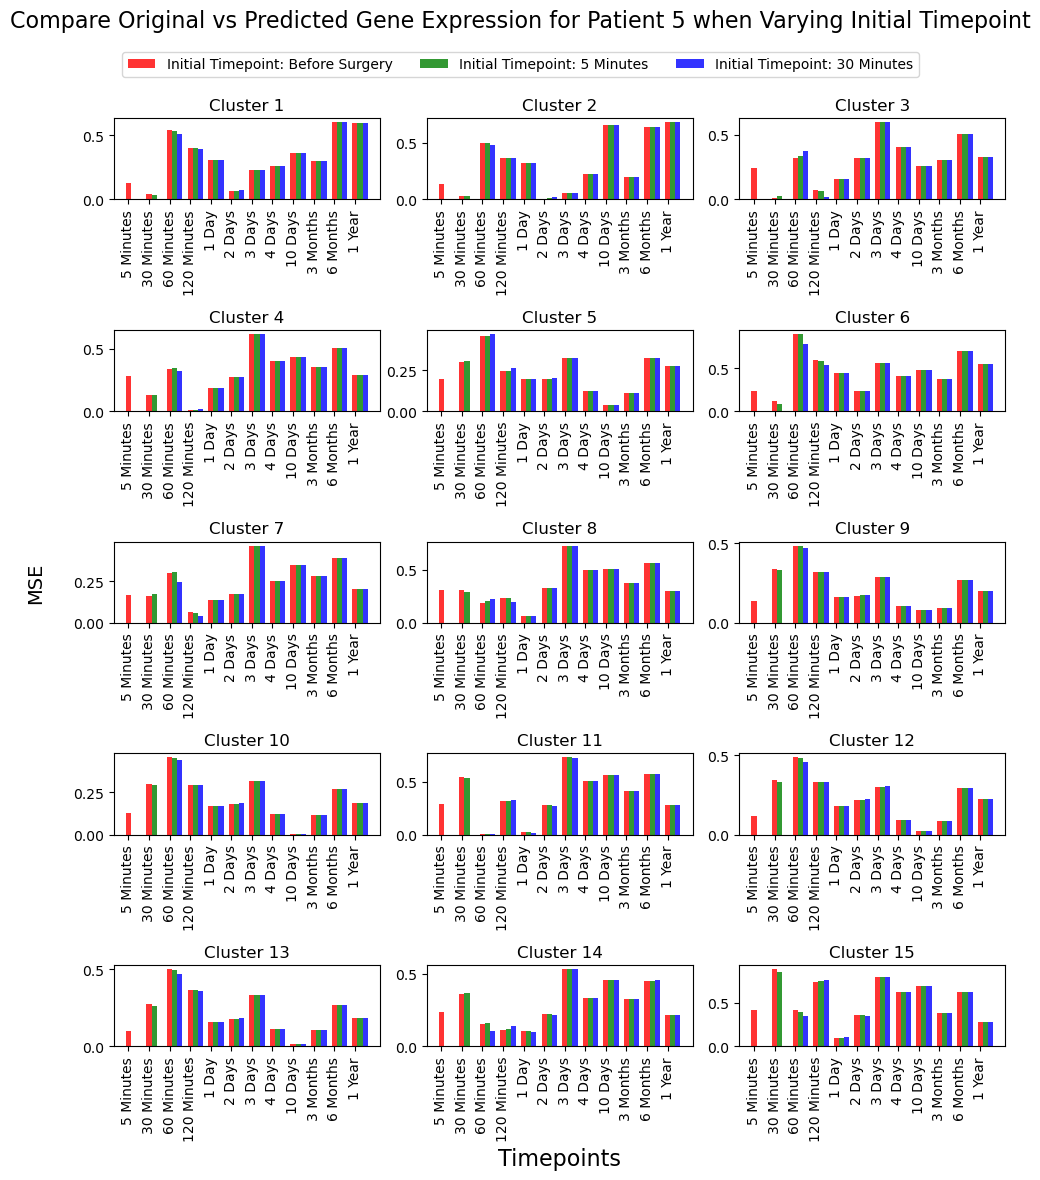

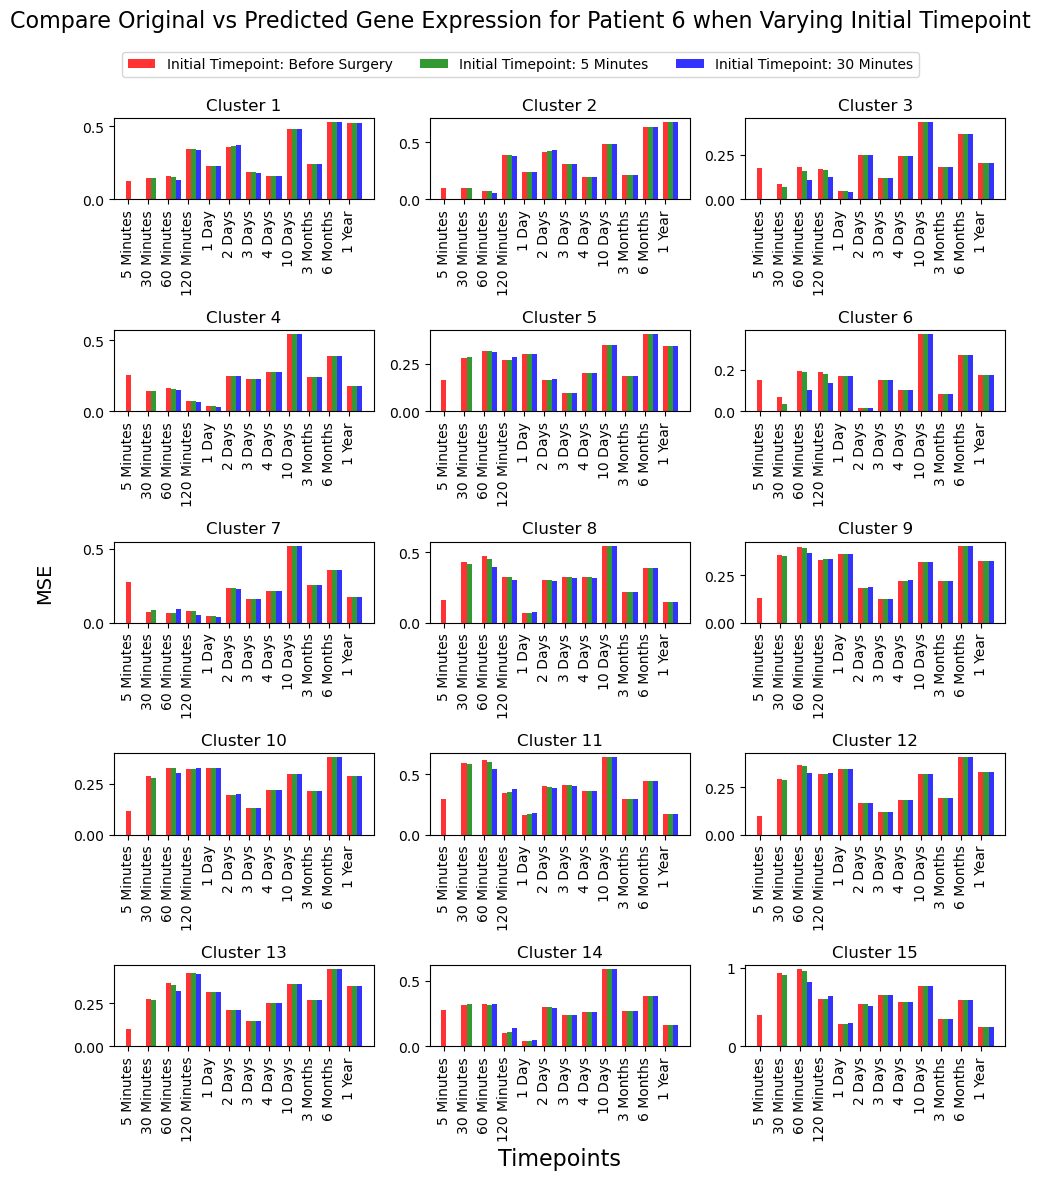

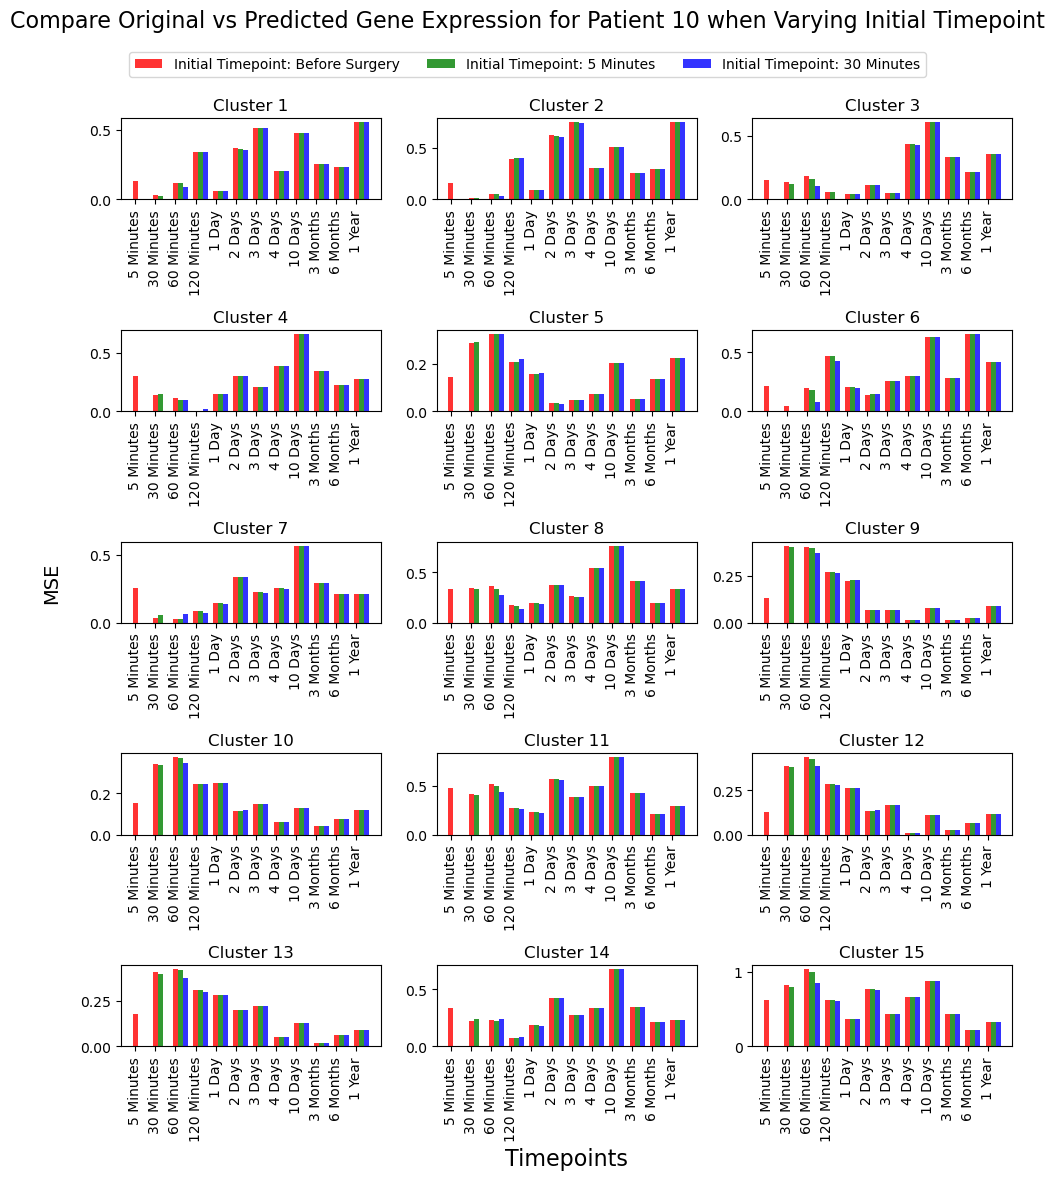

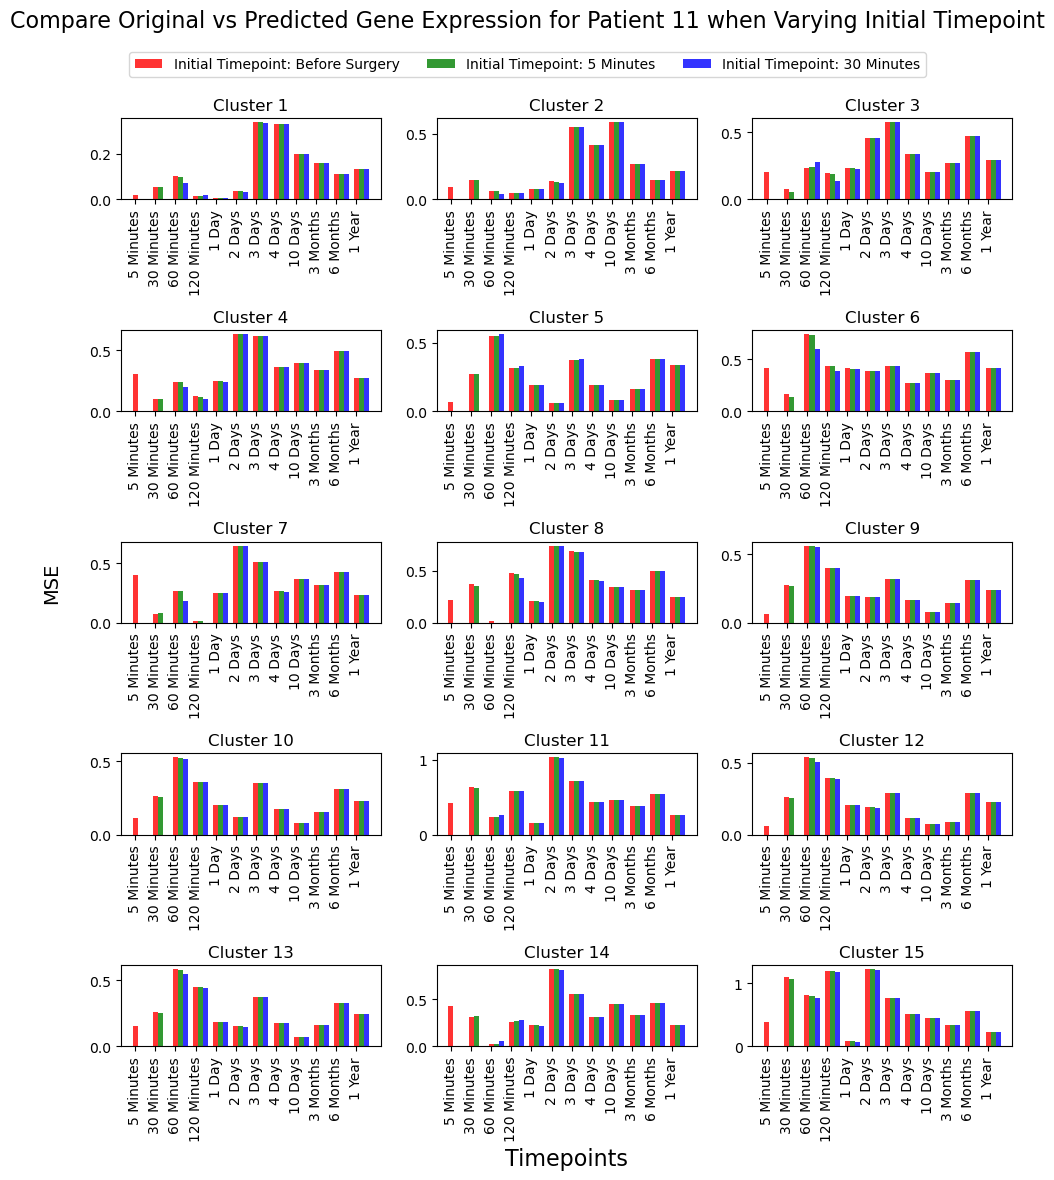

In [65]:

# Loop through each patient
for patient_id in test_patients:
    row_data = test_patient_row_data[patient_id]

    # Define colors for the bars (one for each row)
    colors = ['red', 'green', 'blue']

    # Create a figure and axes for plotting
    fig, axes = plt.subplots(5, 3, figsize=(10, 12))  # Adjusted figure size
    axes = axes.flatten()  # Flatten for easier access to individual subplots

    # Set a title for the entire figure
    fig.suptitle(f"Compare Original vs Predicted Gene Expression for Patient {patient_id} when Varying Initial Timepoint", fontsize=16)


    # Bar width and offset for side-by-side bars
    bar_width = 0.25
    offset = 1  # Adjusted offset for better centering

    # Loop through each cluster and plot in the respective subplot
    for cluster_idx in range(num_clusters):
        ax = axes[cluster_idx]
    
        # Extract the errors corresponding to this cluster (from the 3 rows)
        cluster_data = [entry['errors'] for entry in row_data if entry['cluster_idx'] == cluster_idx]

        # Loop through the three rows of errors and plot bars for each row
        for row_idx, errors in enumerate(cluster_data):
            x_pos = np.arange(len(errors))  # Create x positions for each timepoint
            # print(x_pos)
            # print(row_idx)
            # print(x_pos + row_idx * (bar_width + offset))

            # Plot the bars with different colors for each row
            ax.bar(x_pos + row_idx * (bar_width + offset), errors, width=bar_width, label=f'Initial Timepoint: {timepoint_names[row_idx]}', color=colors[row_idx], alpha=0.8)

        # Set title for each subplot
        ax.set_title(f'Cluster {cluster_idx + 1}')
    
        # Set x-axis labels only for the last two subplots
        if cluster_idx == 13:  # Last two subplots (9th and 10th)
            ax.set_xlabel('Timepoints', fontsize=16)
        else:
            ax.set_xticks([])  # Remove x-ticks for other subplots

        # Set y-axis label only for the 4th subplot
        if cluster_idx == 6:  # 4th subplot (index starts at 0)
            ax.set_ylabel('MSE\n', fontsize=14)

        # Adjust x-ticks to match the number of timepoints in each row
        ax.set_xticks(np.arange(max(len(errors) for errors in cluster_data)))
        ax.set_xticklabels(timepoint_names[1:], rotation=90)

    # Add legend outside the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate legend

    # Save the figure with the appropriate filename and 300 dpi
    filename = f"patient_{patient_id}_error_bars.jpeg"
    fig.savefig(filename, dpi=600)

    plt.show()

   

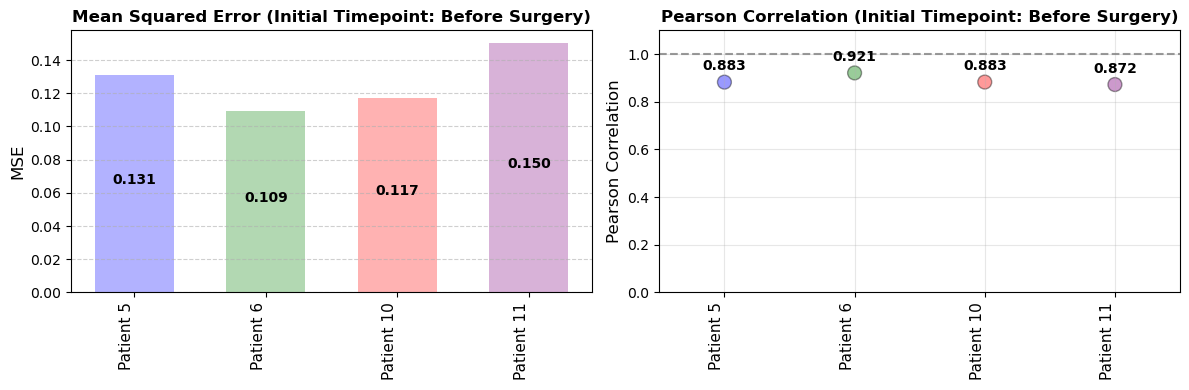

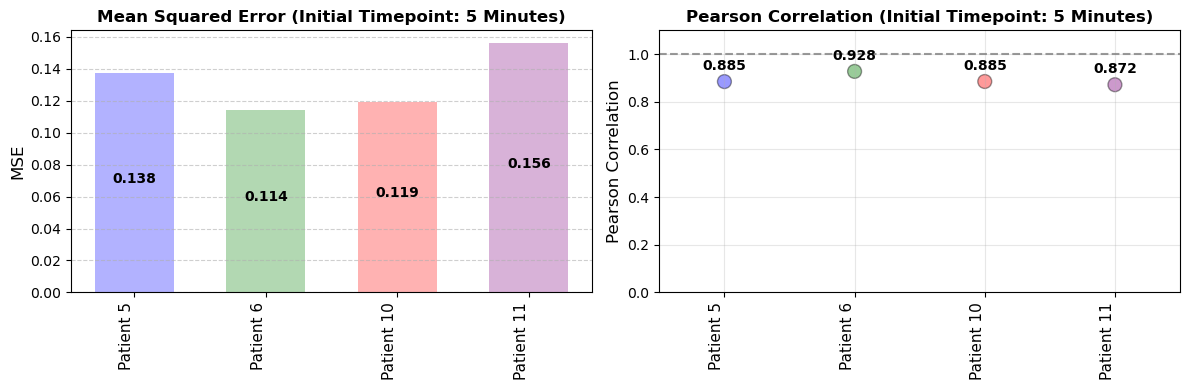

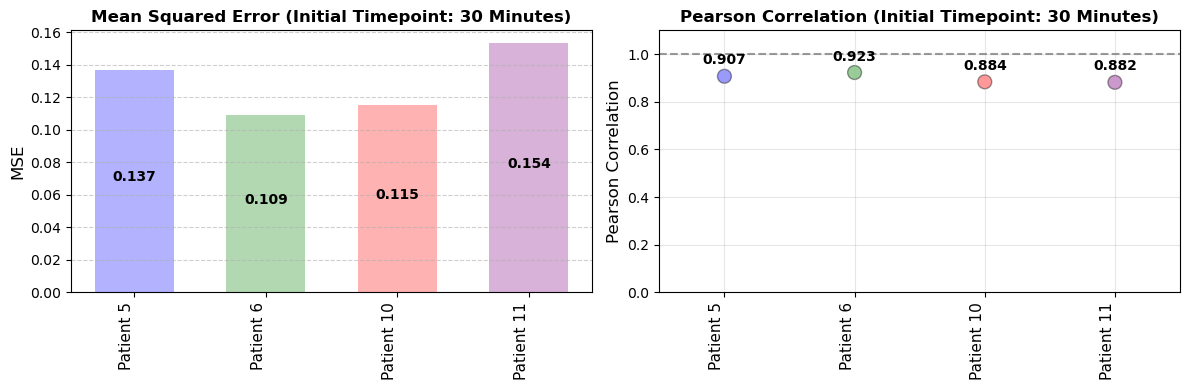

In [66]:

from scipy.stats import pearsonr

num_timepoints = 13
timepoint_values = np.arange(0, num_timepoints)

# Store MSE and Pearson correlation for each patient
mse_values = {}
pearson_values = {}

# Define colors for patients
patient_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']

# Loop through each initial timepoint
for initial_timepoint in initial_timepoints:
    mse_list = []
    pearson_list = []
    patient_labels = []
    
    # Define the future timepoints for comparison
    future_timepoints = np.arange(initial_timepoint + 1, num_timepoints)  # Future predictions
    
    # Loop through each patient
    for idx, patient_id in enumerate(test_patients):
        # Retrieve data for the patient and initial timepoint
        data1 = stored_data[patient_id]
        data = data1[initial_timepoint]['data']

        # Original data (select future timepoints)
        original_mean1 = mean_data[patient_id]
        original_mean = np.array(original_mean1)[:, future_timepoints]  # Shape: (num_clusters, future_timepoints)

        # Predicted data (already corresponds to future timepoints)
        mean_values = np.array(data["mean"])  # Shape: (num_clusters, predicted_timepoints)
        predicted_mean = mean_values[:, :len(future_timepoints)]  # Ensure correct slicing

        # Compute MSE and Pearson correlation per cluster
        mse_per_cluster = np.mean((original_mean - predicted_mean) ** 2, axis=1)  # Per cluster
        mse = np.mean(mse_per_cluster)  # Average across clusters
        mse_list.append(mse)

        # Compute Pearson correlation per cluster
        pearson_per_cluster = [
            pearsonr(original_mean[cl], predicted_mean[cl])[0] for cl in range(original_mean.shape[0])
        ]
        pearson = np.mean(pearson_per_cluster)  # Average across clusters
        pearson_list.append(pearson)

        # Store patient label
        patient_labels.append(f"Patient {patient_id}")

    # Store values for plotting
    mse_values[initial_timepoint] = mse_list
    pearson_values[initial_timepoint] = pearson_list

    # Plot MSE and Pearson Correlation
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # **Bar plot for MSE**
    bars = axes[0].bar(patient_labels, mse_list, width=0.6, color=patient_colors[:len(patient_labels)], alpha=0.3)
    axes[0].set_title(f"Mean Squared Error (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[0].set_ylabel("MSE", fontsize=12)
    axes[0].set_xticks(range(len(patient_labels)))  
    axes[0].set_xticklabels(patient_labels, rotation=90, ha="right", fontsize=11)
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)

    # **Add values on top of bars**
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, height - (height/2), f'{height:.3f}', ha='center', fontsize=10, fontweight='bold')

    # **Scatter plot for Pearson Correlation**
    axes[1].scatter(range(len(patient_labels)), pearson_list, color=patient_colors[:len(patient_labels)], s=100, edgecolors='black', alpha=0.4)
    axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.8)  # Reference line at r = 1
    axes[1].set_xlim(-0.5, len(patient_labels) - 0.5)  # This will tighten the spacing between points
    axes[1].set_ylim(0, 1.1)
    axes[1].set_title(f"Pearson Correlation (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("Pearson Correlation", fontsize=12)
    axes[1].set_xticks(range(len(patient_labels)))
    axes[1].set_xticklabels(patient_labels, rotation=90, ha="right", fontsize=11)
    axes[1].grid(alpha=0.3)

    # **Add values on top of scatter points**
    for i, txt in enumerate(pearson_list):
        axes[1].text(i, pearson_list[i] + 0.05, f'{txt:.3f}', ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()

    # Save the figure with the appropriate filename and 600 dpi
    filename = f"MSE_initial_timepoint_{timepoint_names[initial_timepoint]}.jpeg"
    fig.savefig(filename, dpi=600)
    
    plt.show()


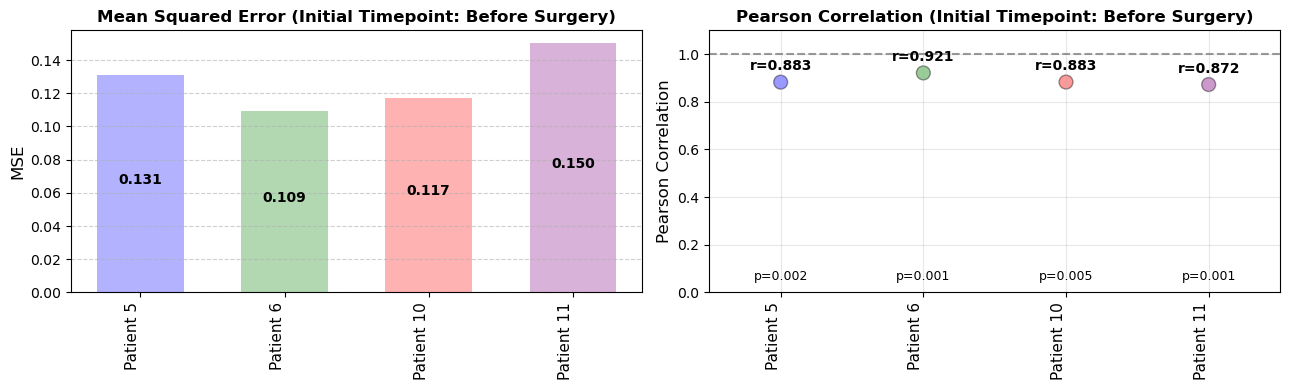

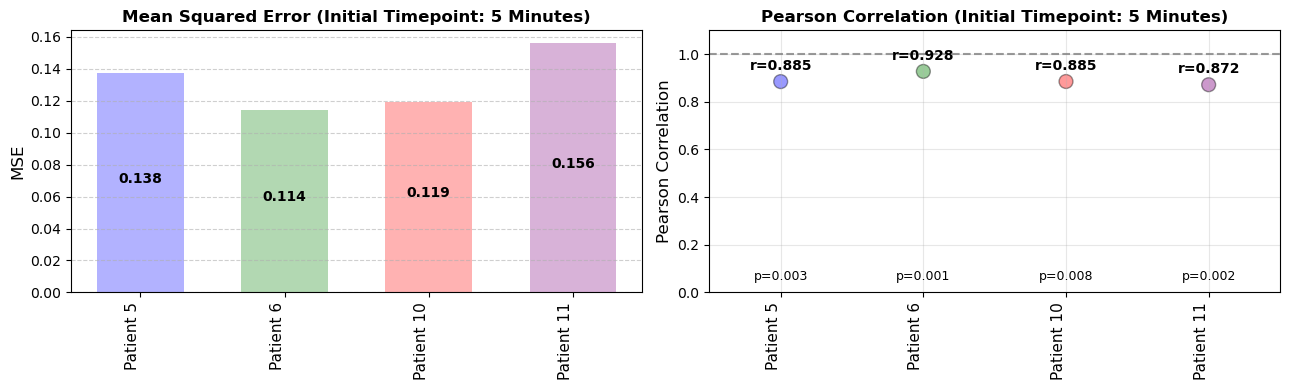

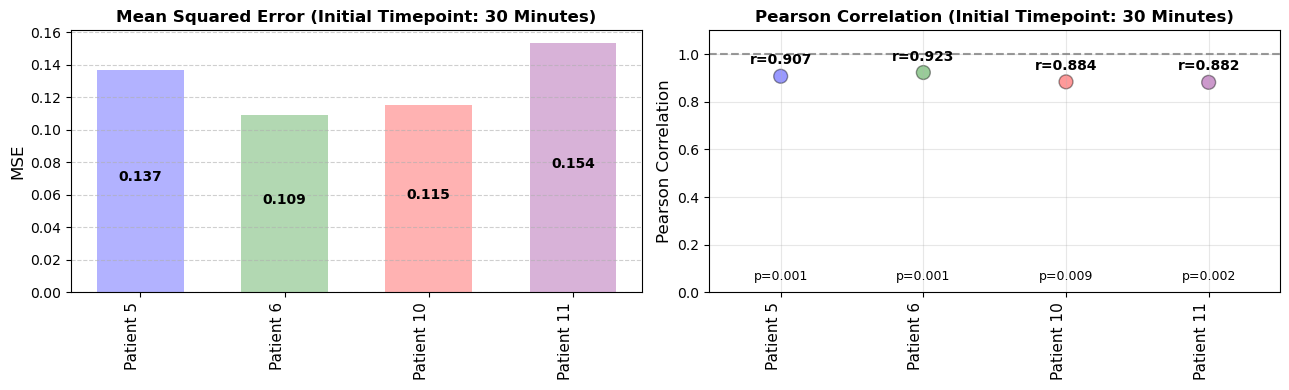

In [67]:

num_timepoints = 13
timepoint_values = np.arange(0, num_timepoints)

# Store MSE, Pearson correlation, and p-values for each patient
mse_values = {}
pearson_values = {}
pvalue_values = {}

# Define colors for patients
patient_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']

# Loop through each initial timepoint
for initial_timepoint in initial_timepoints:
    mse_list = []
    pearson_list = []
    pvalue_list = []
    patient_labels = []
    
    # Define the future timepoints for comparison
    future_timepoints = np.arange(initial_timepoint + 1, num_timepoints)
    
    # Loop through each patient
    for idx, patient_id in enumerate(test_patients):
        # Retrieve data for the patient and initial timepoint
        data1 = stored_data[patient_id]
        data = data1[initial_timepoint]['data']

        # Original data (select future timepoints)
        original_mean1 = mean_data[patient_id]
        original_mean = np.array(original_mean1)[:, future_timepoints]

        # Predicted data (already corresponds to future timepoints)
        mean_values = np.array(data["mean"])
        predicted_mean = mean_values[:, :len(future_timepoints)]

        # Compute MSE per cluster
        mse_per_cluster = np.mean((original_mean - predicted_mean) ** 2, axis=1)
        mse = np.mean(mse_per_cluster)
        mse_list.append(mse)

        # Compute Pearson correlation and p-value per cluster
        pearson_r_per_cluster = []
        pearson_p_per_cluster = []

        for cl in range(original_mean.shape[0]):
            r_val, p_val = pearsonr(original_mean[cl], predicted_mean[cl])
            pearson_r_per_cluster.append(r_val)
            pearson_p_per_cluster.append(p_val)

        pearson = np.mean(pearson_r_per_cluster)
        p_value = np.mean(pearson_p_per_cluster)
        pearson_list.append(pearson)
        pvalue_list.append(p_value)

        patient_labels.append(f"Patient {patient_id}")

    # Store for each timepoint
    mse_values[initial_timepoint] = mse_list
    pearson_values[initial_timepoint] = pearson_list
    pvalue_values[initial_timepoint] = pvalue_list

    # Plot MSE and Pearson Correlation
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    # Bar plot for MSE
    bars = axes[0].bar(patient_labels, mse_list, width=0.6, color=patient_colors[:len(patient_labels)], alpha=0.3)
    axes[0].set_title(f"Mean Squared Error (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[0].set_ylabel("MSE", fontsize=12)
    axes[0].set_xticks(range(len(patient_labels)))
    axes[0].set_xticklabels(patient_labels, rotation=90, ha="right", fontsize=11)
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)

    # Add MSE values on top
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, height - (height/2), f'{height:.3f}', ha='center', fontsize=10, fontweight='bold')

    # Scatter plot for Pearson Correlation
    axes[1].scatter(range(len(patient_labels)), pearson_list, color=patient_colors[:len(patient_labels)], s=100, edgecolors='black', alpha=0.4)
    axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.8)
    axes[1].set_xlim(-0.5, len(patient_labels) - 0.5)
    axes[1].set_ylim(0, 1.1)
    axes[1].set_title(f"Pearson Correlation (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("Pearson Correlation", fontsize=12)
    axes[1].set_xticks(range(len(patient_labels)))
    axes[1].set_xticklabels(patient_labels, rotation=90, ha="right", fontsize=11)
    axes[1].grid(alpha=0.3)

    # Add r and p-values as text annotations
    for i in range(len(patient_labels)):
        axes[1].text(i, pearson_list[i] + 0.05, f'r={pearson_list[i]:.3f}', ha='center', fontsize=10, fontweight='bold')
        axes[1].text(i, 0.05, f'p={pvalue_list[i]:.3f}', ha='center', fontsize=9, color='black')

    plt.tight_layout()

    # Save figure
    filename = f"MSE_initial_timepoint_{timepoint_names[initial_timepoint]}.jpeg"
    fig.savefig(filename, dpi=600)
    
    plt.show()


In [68]:


# Load missing timepoints data
missing_df = pd.read_excel("missing_timepoints.xlsx")

# Extract patient numbers and missing timepoints (skip first column)
patients_missing_data = missing_df.set_index(missing_df.columns[0]).iloc[:, 1:].to_numpy()

# Convert to a dictionary for easy lookup
missing_dict = {patient: missing for patient, missing in zip(range(1, 13), patients_missing_data)}


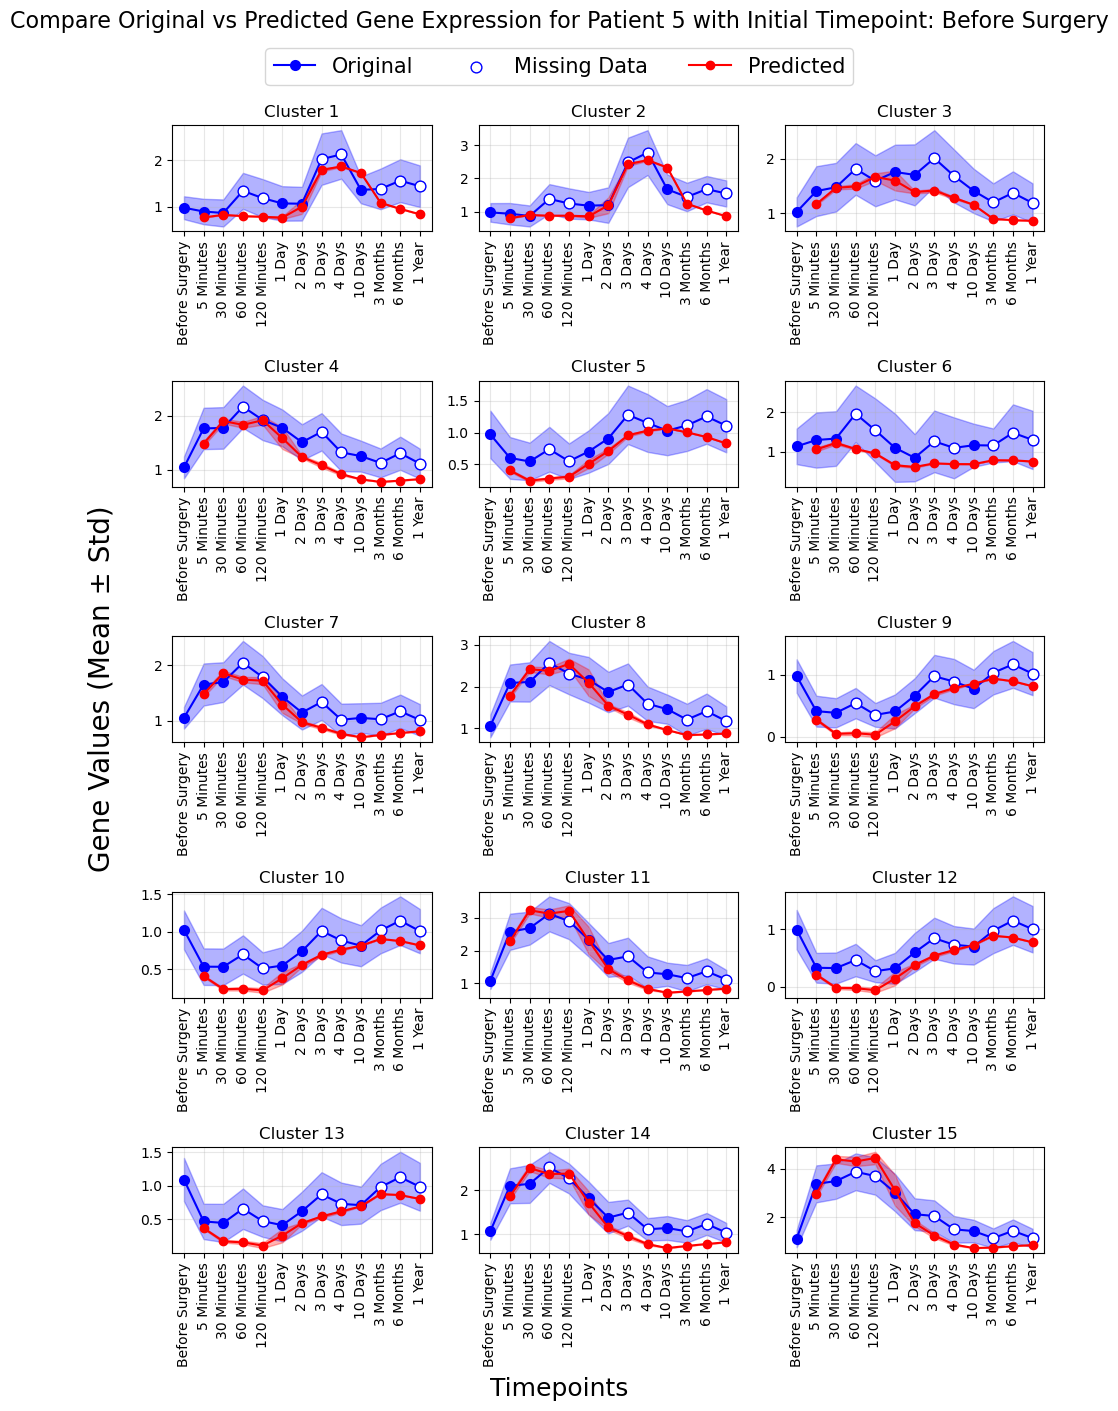

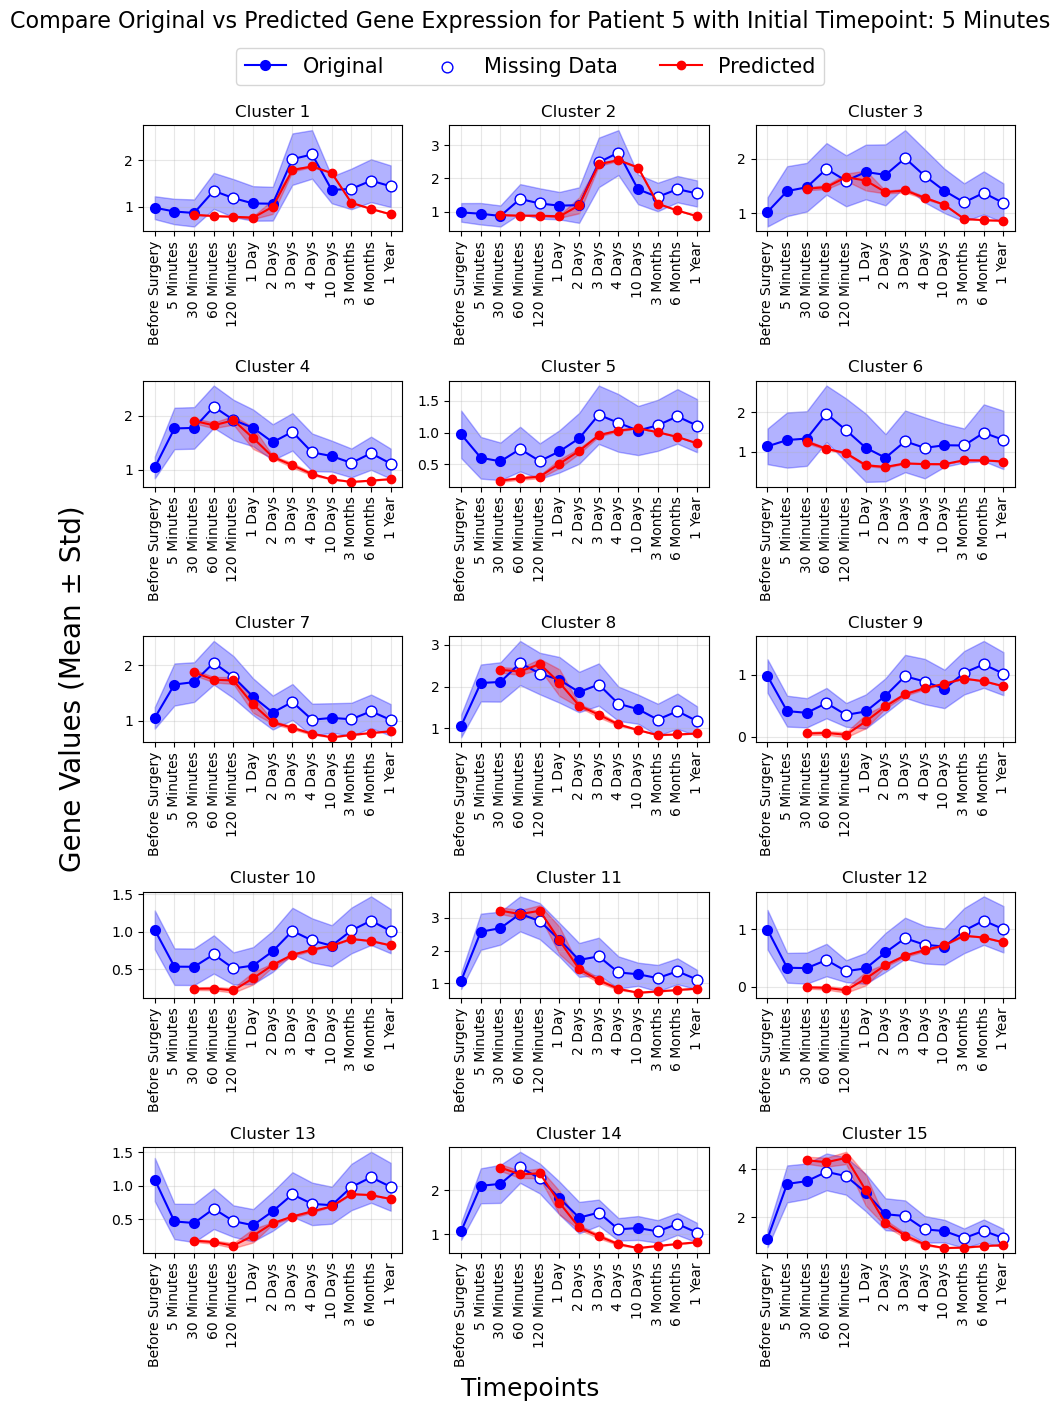

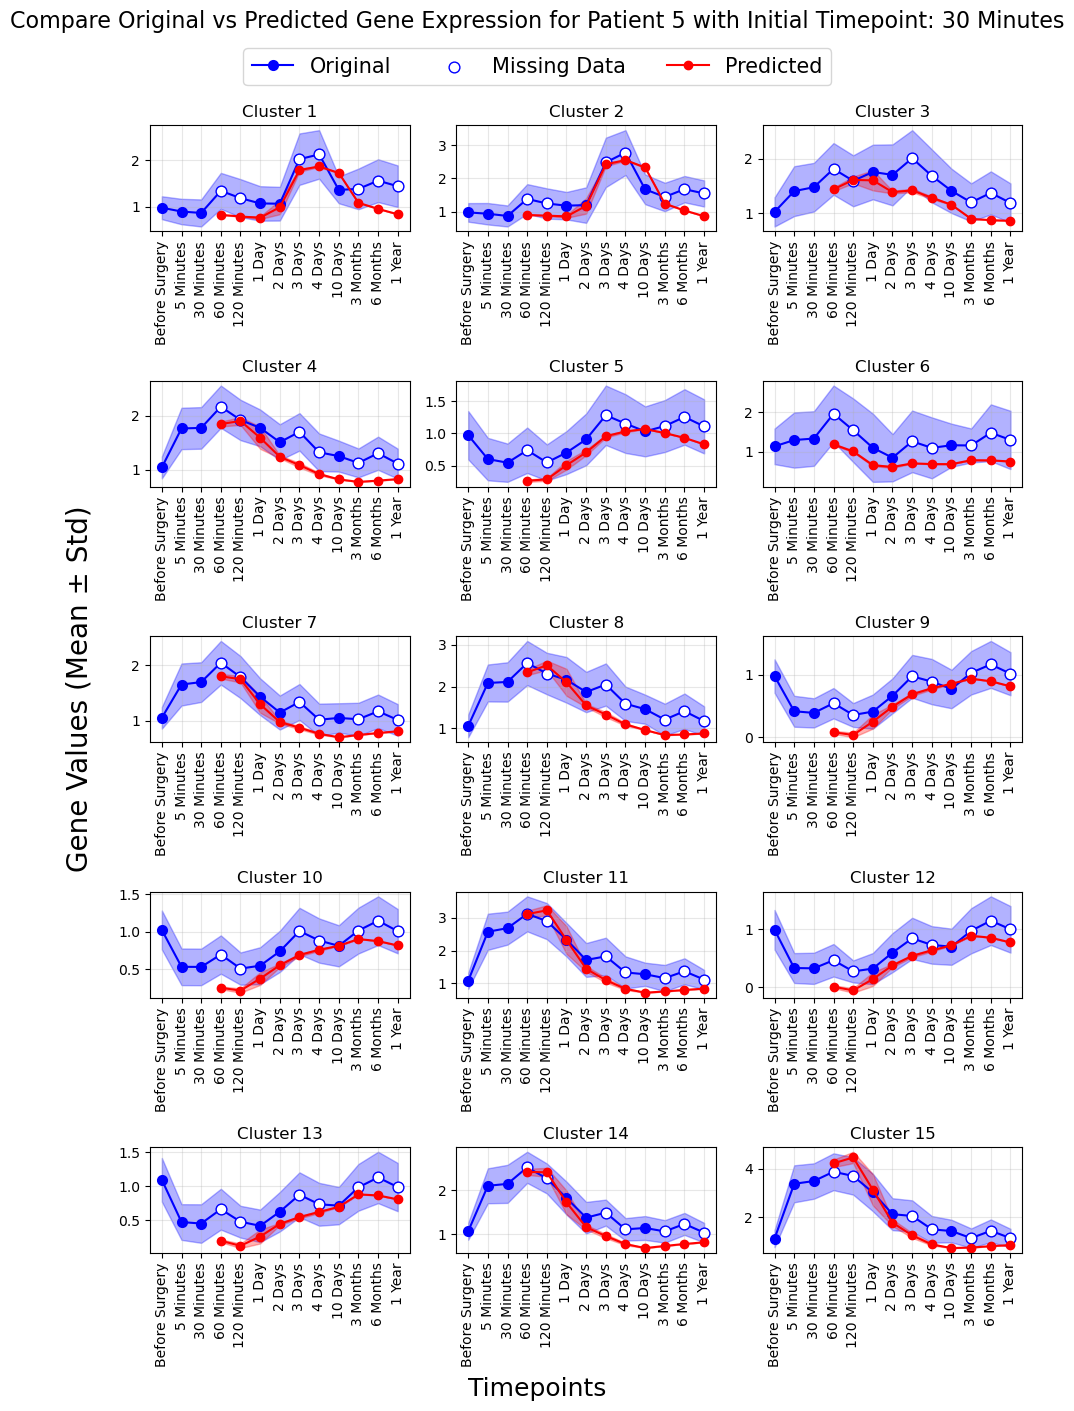

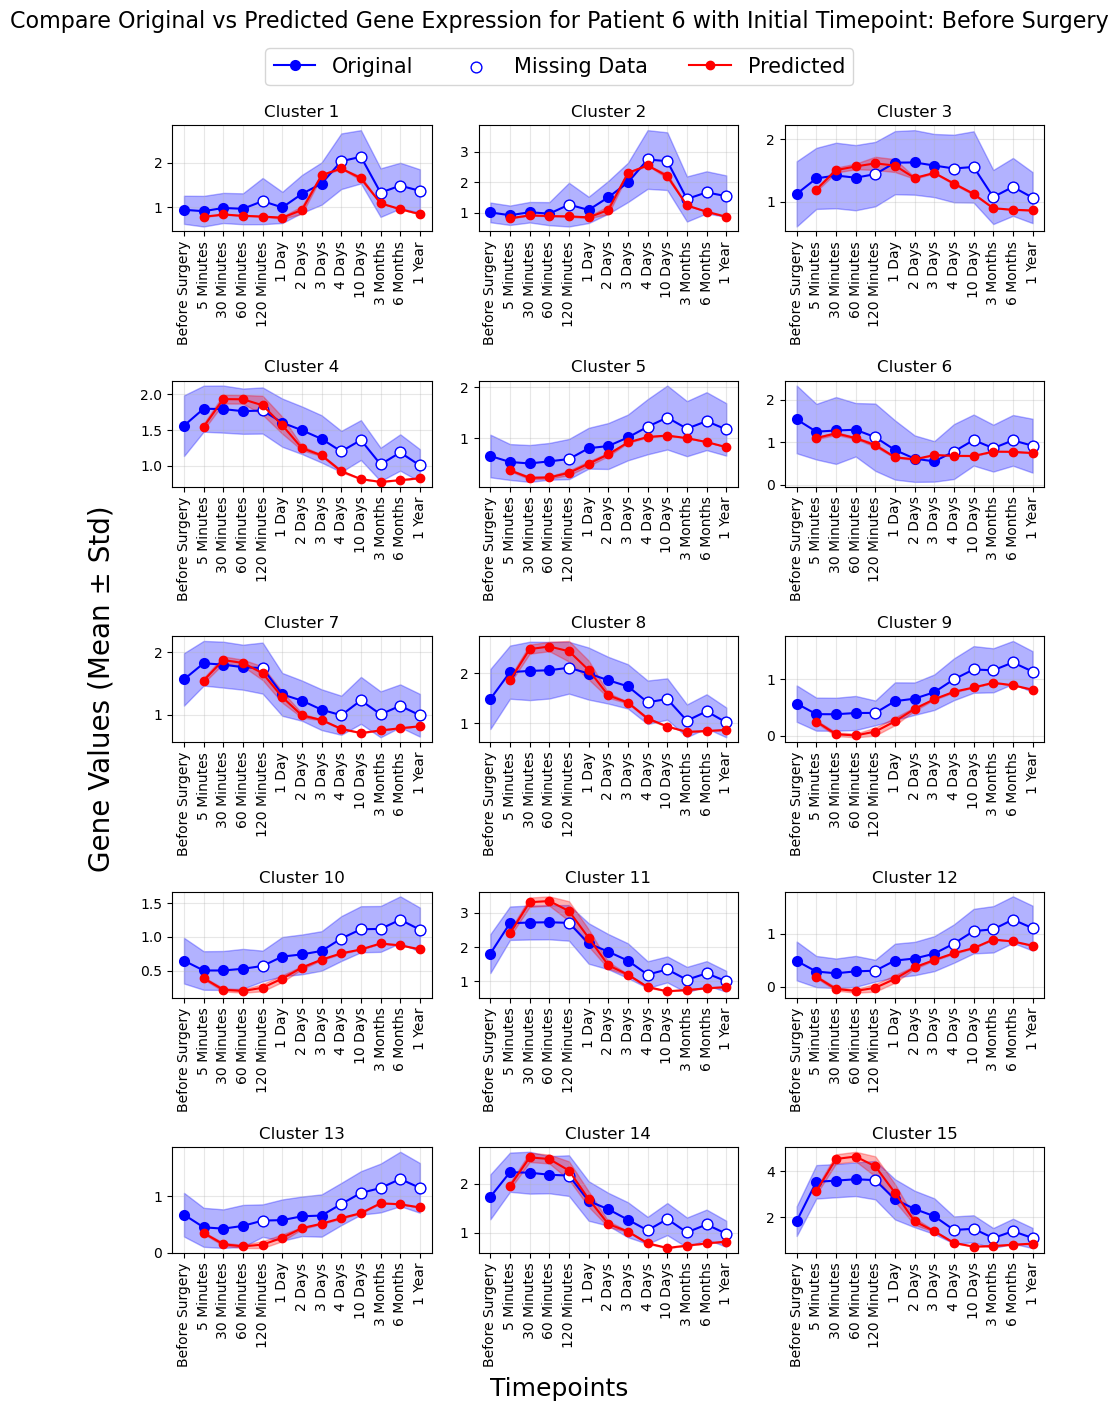

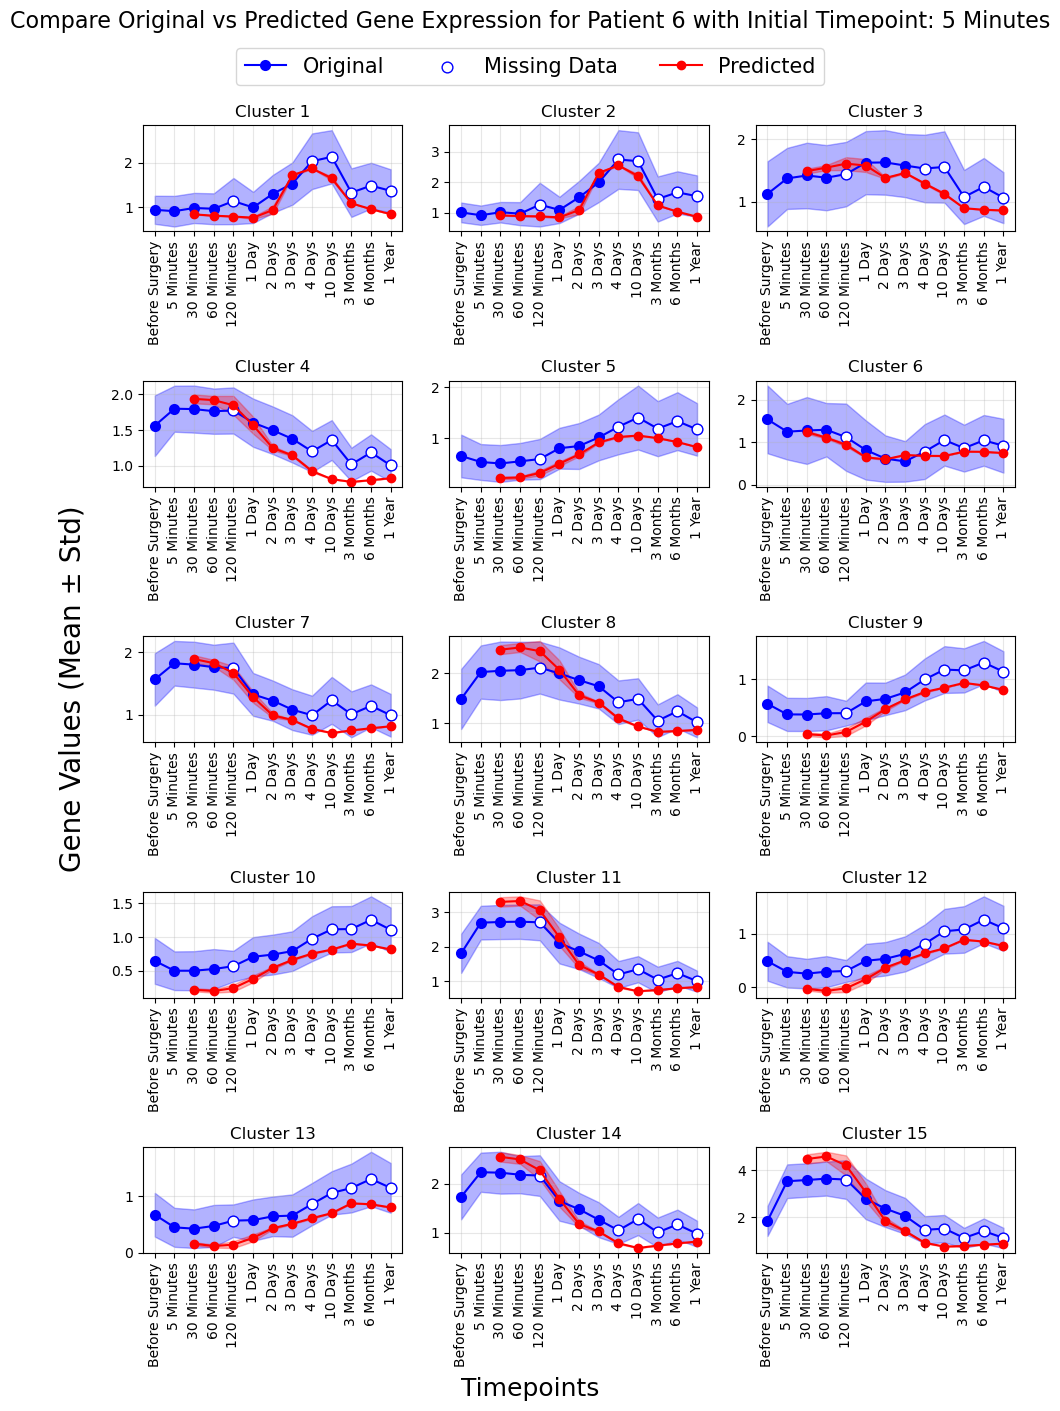

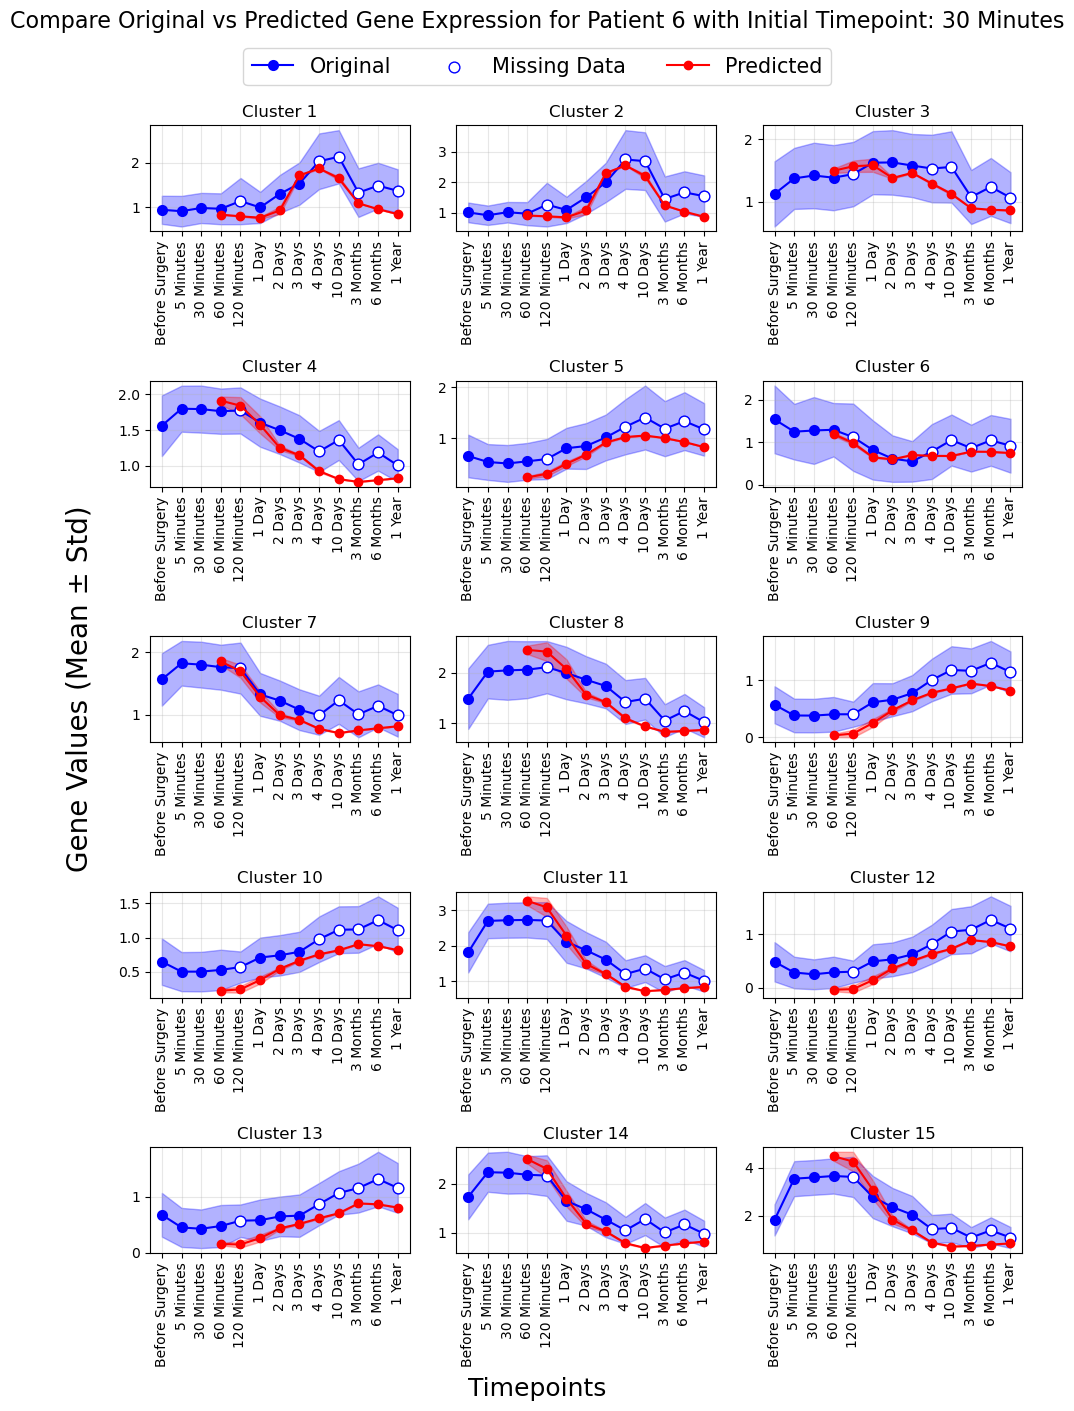

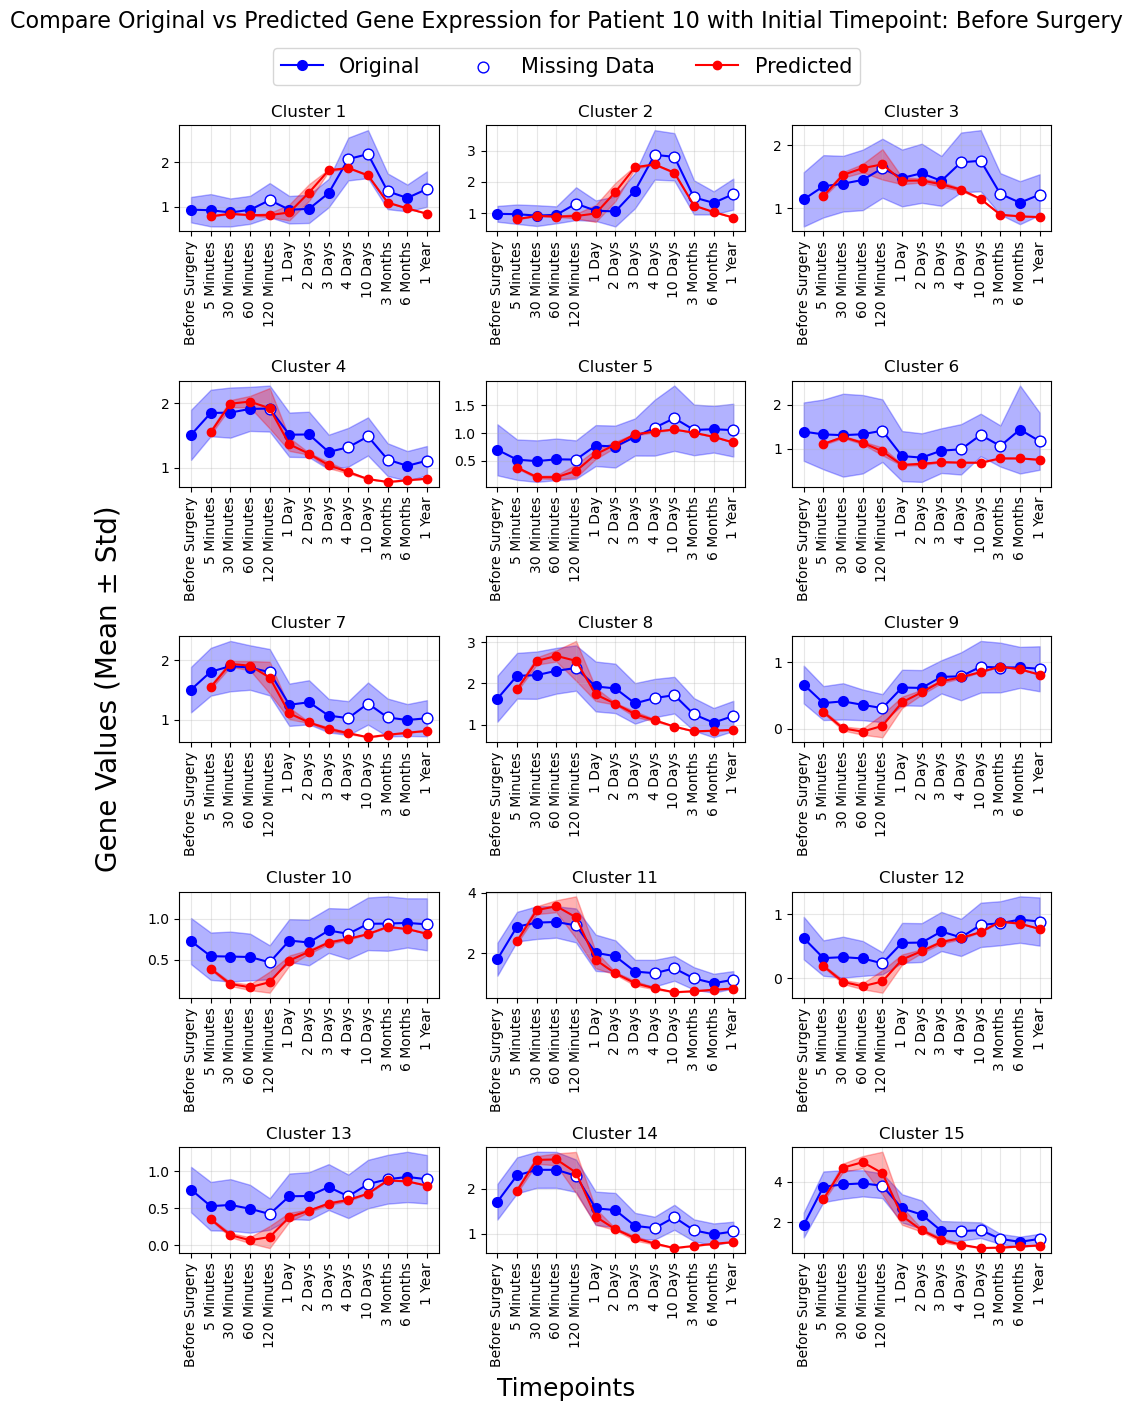

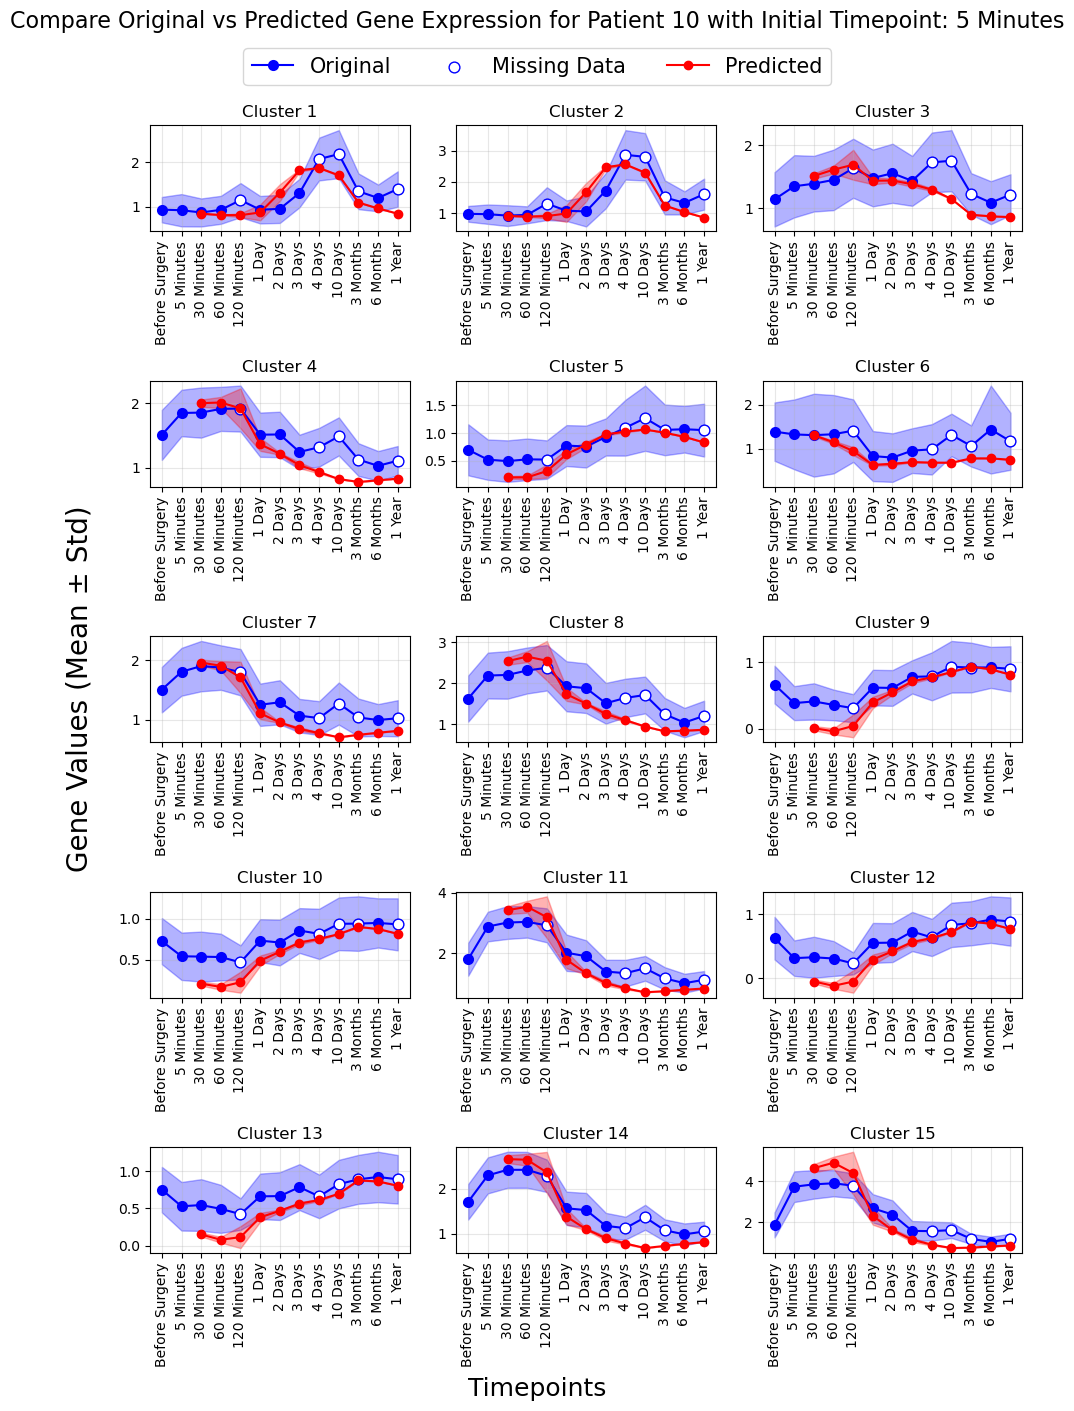

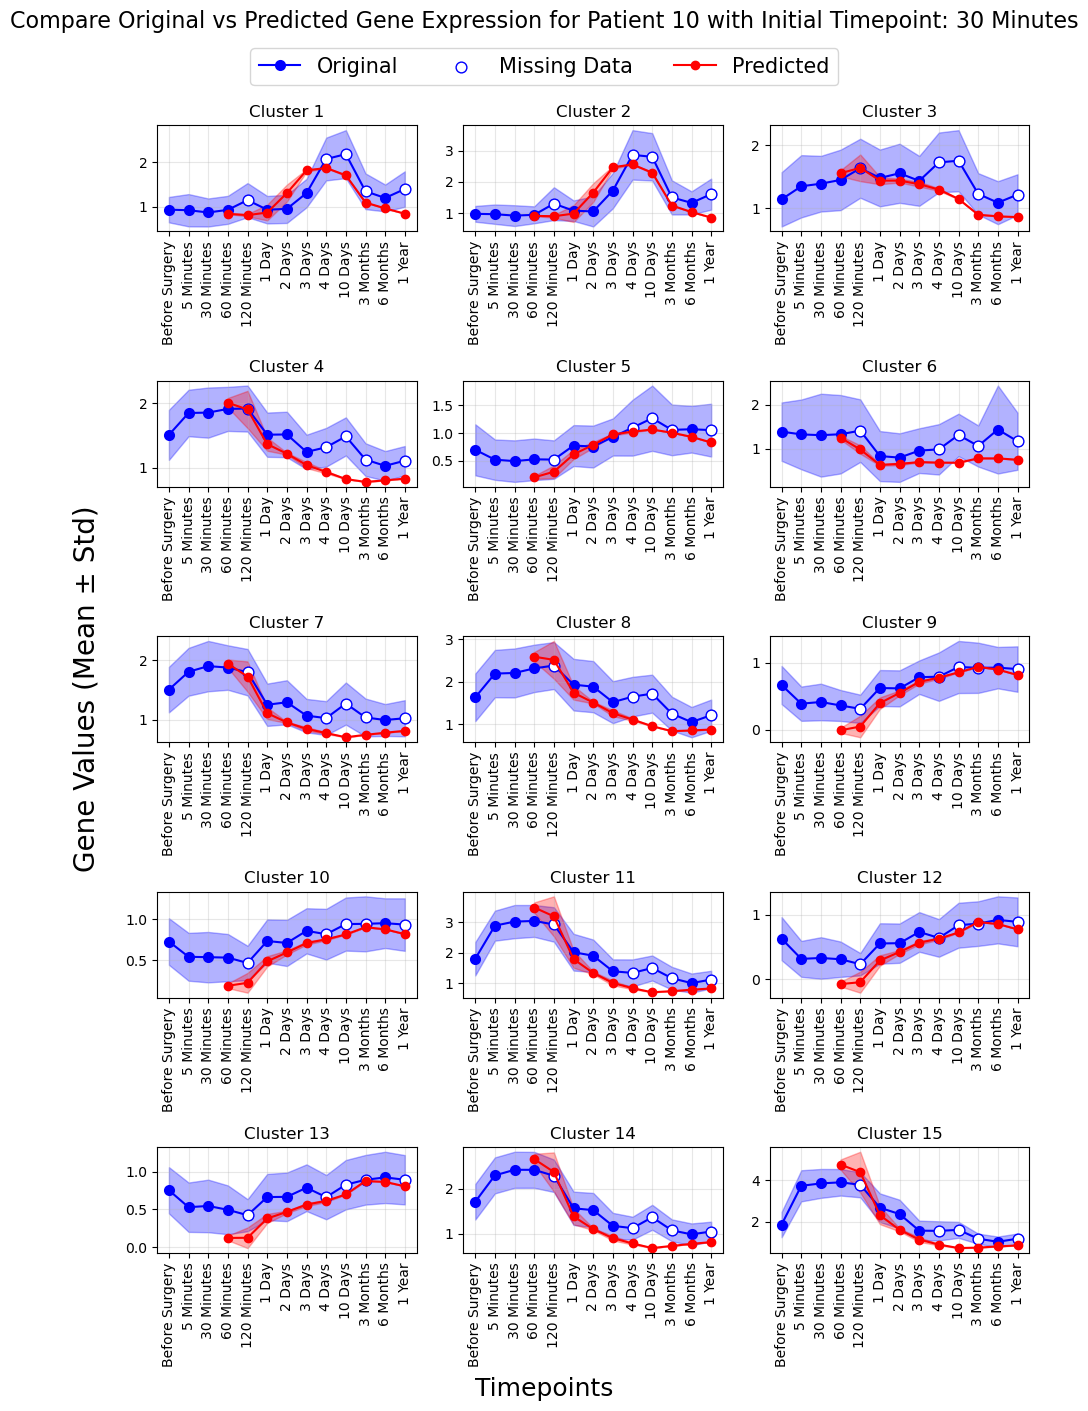

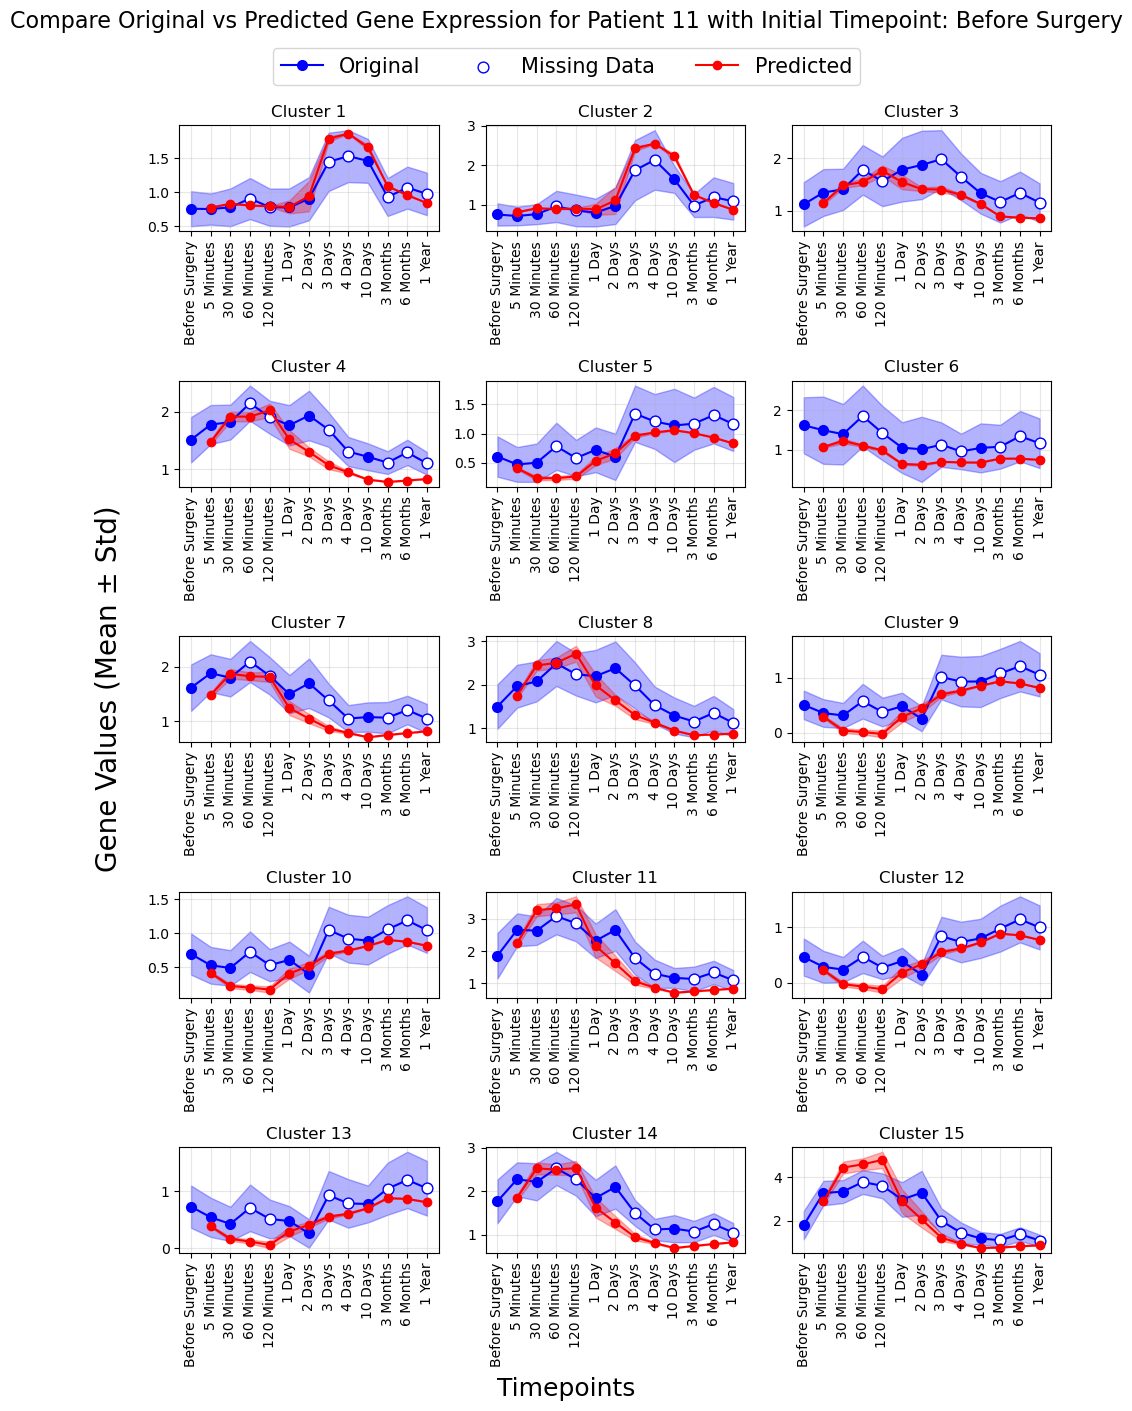

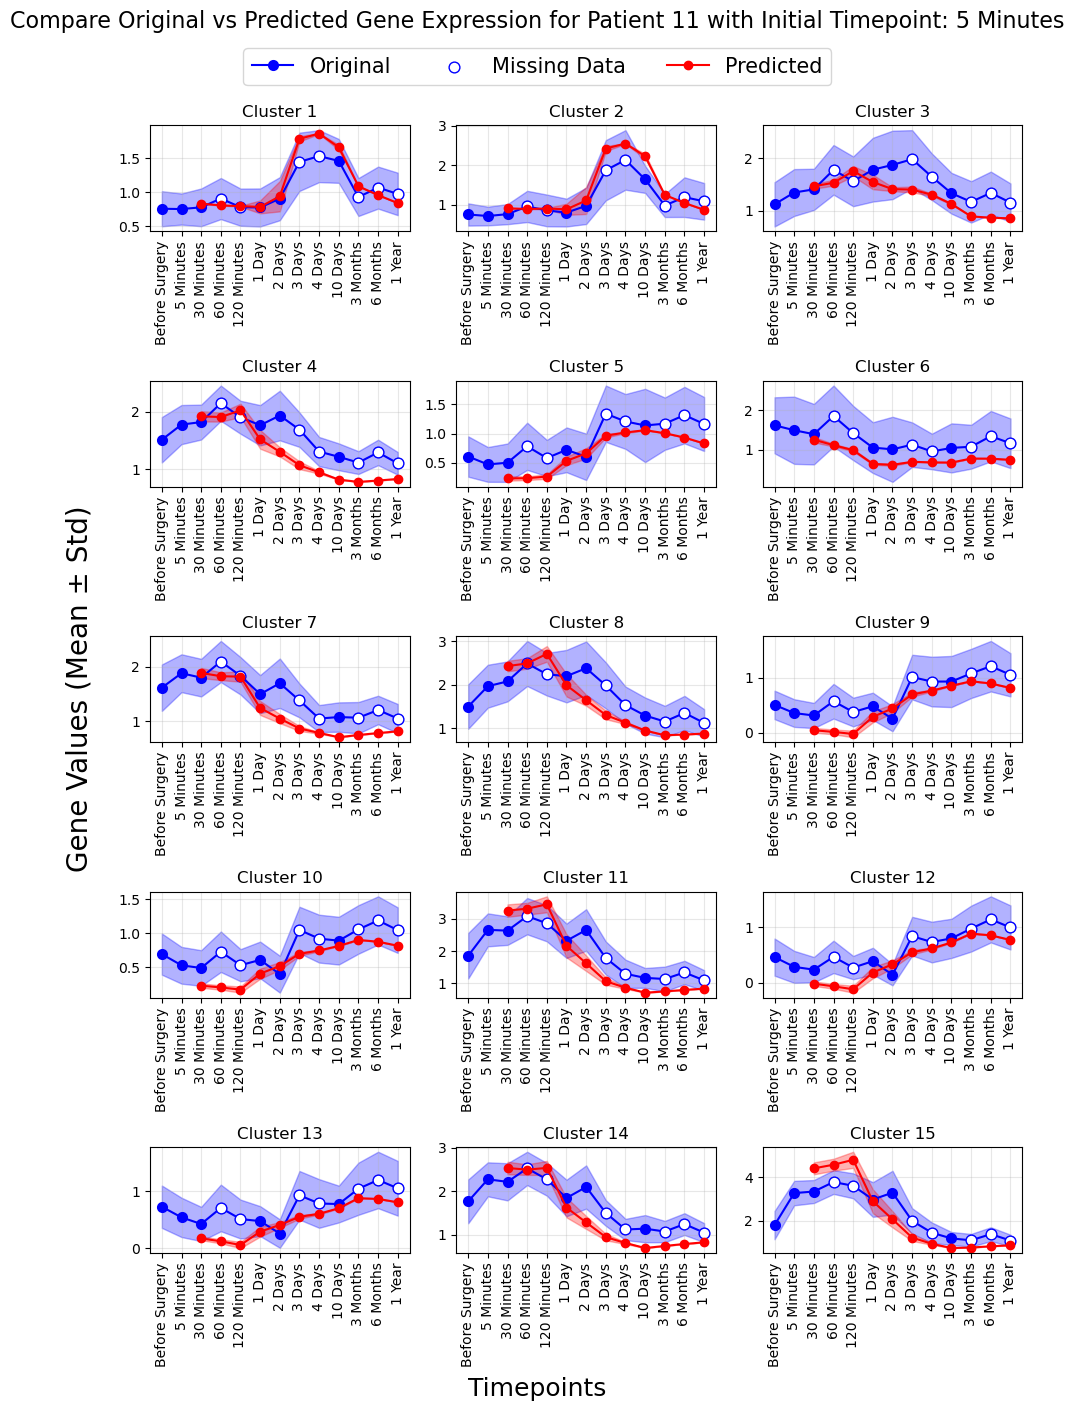

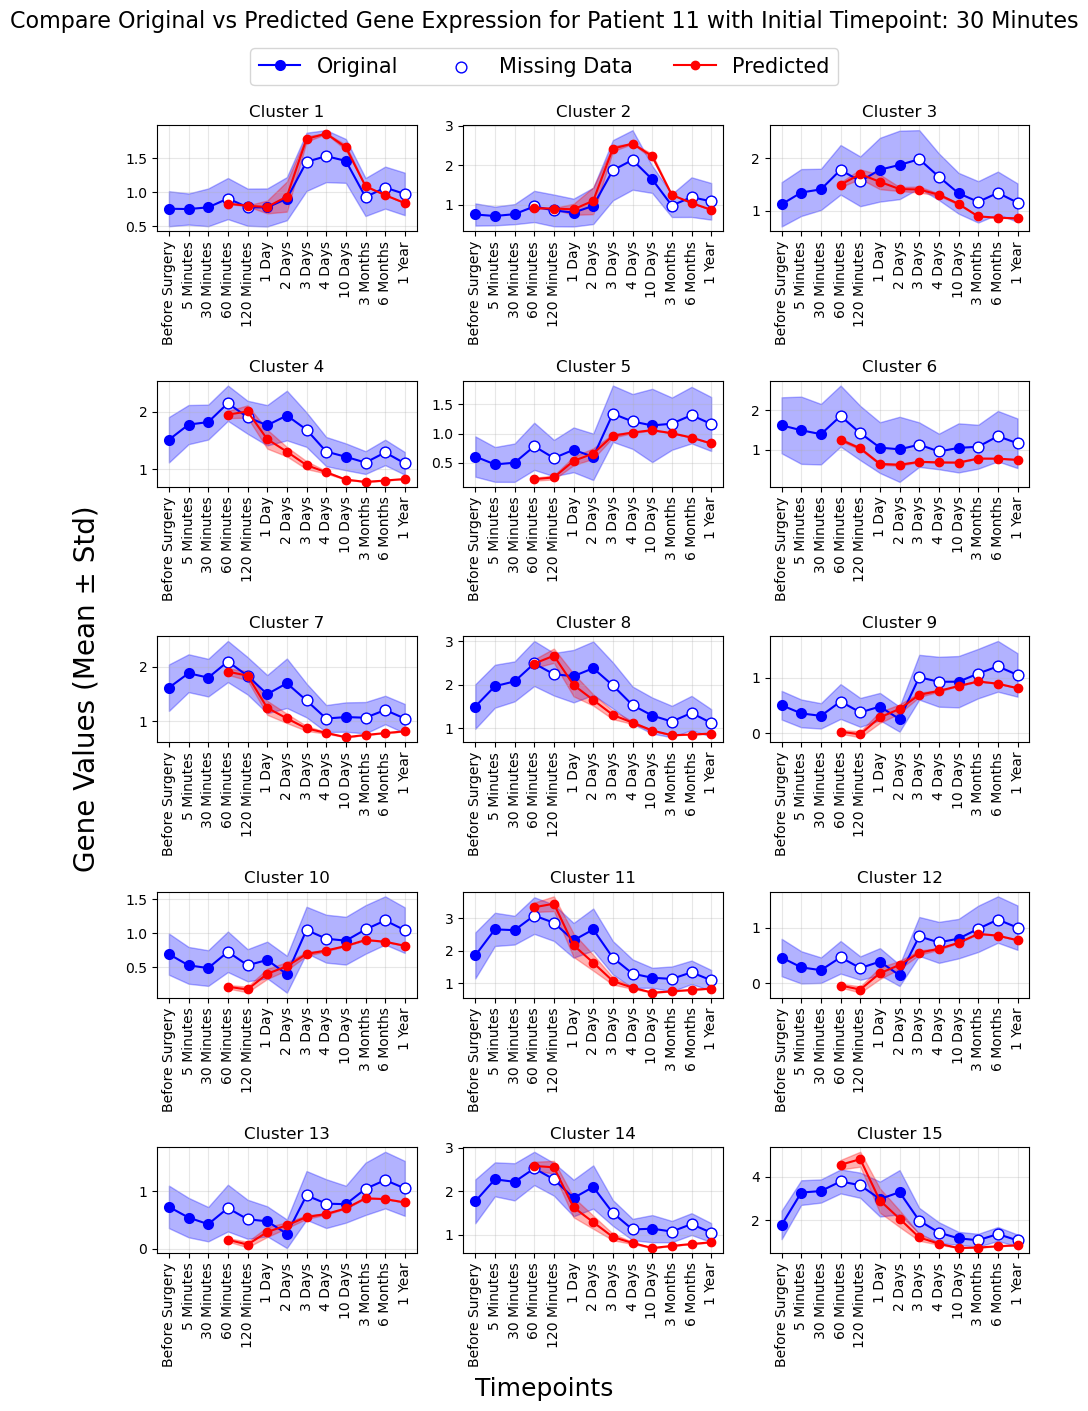

In [69]:
# ================================================================================================
# Plot the mean and standard deviation of gene values: original vs predicted data (using patches)
# ================================================================================================

# Define the timepoint column name based on the timepoint index
num_timepoints = 13
timepoint_values = np.arange(0, num_timepoints)

# Loop through each patient
for patient_id in test_patients:
    
    # Loop through each initial timepoint
    for initial_timepoint in initial_timepoints:
        # Process data for the specific initial timepoint
        data1 = stored_data[patient_id]
        data = data1[initial_timepoint]['data']

        timepoint_values_p = np.arange(initial_timepoint + 1, 13)  # Prediction is always the next timepoint
        
        # Select specific timepoint names based on index
        timepoint_names_o = [timepoint_names[i] for i in timepoint_values]
        timepoint_names_p = [timepoint_names[i] for i in timepoint_values_p]

        # Create a figure and axes for plotting
        fig, axes = plt.subplots(5, 3, figsize=(10, 14))  # Adjusted figure size
        axes = axes.flatten()  # Flatten for easier access to individual subplots

        # Set a title for the entire figure
        fig.suptitle(f"Compare Original vs Predicted Gene Expression for Patient {patient_id} with Initial Timepoint: {timepoint_names[initial_timepoint]}", fontsize=16)

        # Loop through each cluster
        for cluster_idx in range(num_clusters):
            original_mean1 = mean_data[patient_id]
            original_mean = original_mean1[cluster_idx]
            
            original_std1 = std_data[patient_id]
            original_std = original_std1[cluster_idx]

            # Predicted values
            mean_values = np.array(data["mean"])
            predicted_mean = mean_values[cluster_idx]
            
            std_values = np.array(data["std"])
            predicted_std = std_values[cluster_idx]

            # Identify missing timepoints for this patient
            missing_mask = np.array(missing_dict[patient_id][0:]) == 0  # Start from the 2nd column

            # Plot the original data (Available: Filled, Missing: Empty)
            axes[cluster_idx].fill_between(timepoint_names_o, 
                                           original_mean - original_std, 
                                           original_mean + original_std, 
                                           color='blue', alpha=0.3, zorder=1)  # Keep shaded area behind everything
            axes[cluster_idx].plot(timepoint_names_o, original_mean, '-o', color='blue', label="Original",
                                   markerfacecolor='blue', markeredgewidth=2, zorder=2)  # Ensure original line is above shaded area

            # Mark missing data with empty markers (Plotted Last)
            axes[cluster_idx].scatter(np.array(timepoint_names_o)[missing_mask], original_mean[missing_mask],
                                      edgecolor='blue', facecolor='white', s=60, label="Missing Data", zorder=2)  # Higher zorder for visibility

            # Plot the predicted data
            axes[cluster_idx].plot(timepoint_names_p, predicted_mean, '-o', color='red', label="Predicted", zorder=2)
            axes[cluster_idx].fill_between(timepoint_names_p, 
                                           predicted_mean - predicted_std, 
                                           predicted_mean + predicted_std, 
                                           color='red', alpha=0.3, zorder=1)

            axes[cluster_idx].set_xticks(timepoint_names_o)  
            axes[cluster_idx].set_xticklabels(timepoint_names_o, rotation=90)  
            axes[cluster_idx].set_title(f"Cluster {cluster_idx + 1}", fontsize=12)
            axes[cluster_idx].grid(alpha=0.3)
            if cluster_idx == 6:
                axes[cluster_idx].set_ylabel("Gene Values (Mean ± Std)\n", fontsize=20)

        # Set the x-axis labels across all subplots
        fig.text(0.5, -0.01, 'Timepoints', ha='center', fontsize=18)

        # Add legend outside the figure
        handles, labels = axes[cluster_idx].get_legend_handles_labels()
        fig.legend(handles, labels, fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)

        # Adjust layout to avoid overlap
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate legend

        # Save the figure with the appropriate filename and 600 dpi
        filename = f"patient_{patient_id}_initial_timepoint_{timepoint_names[initial_timepoint]}.jpeg"
        fig.savefig(filename, dpi=600)

        plt.show()


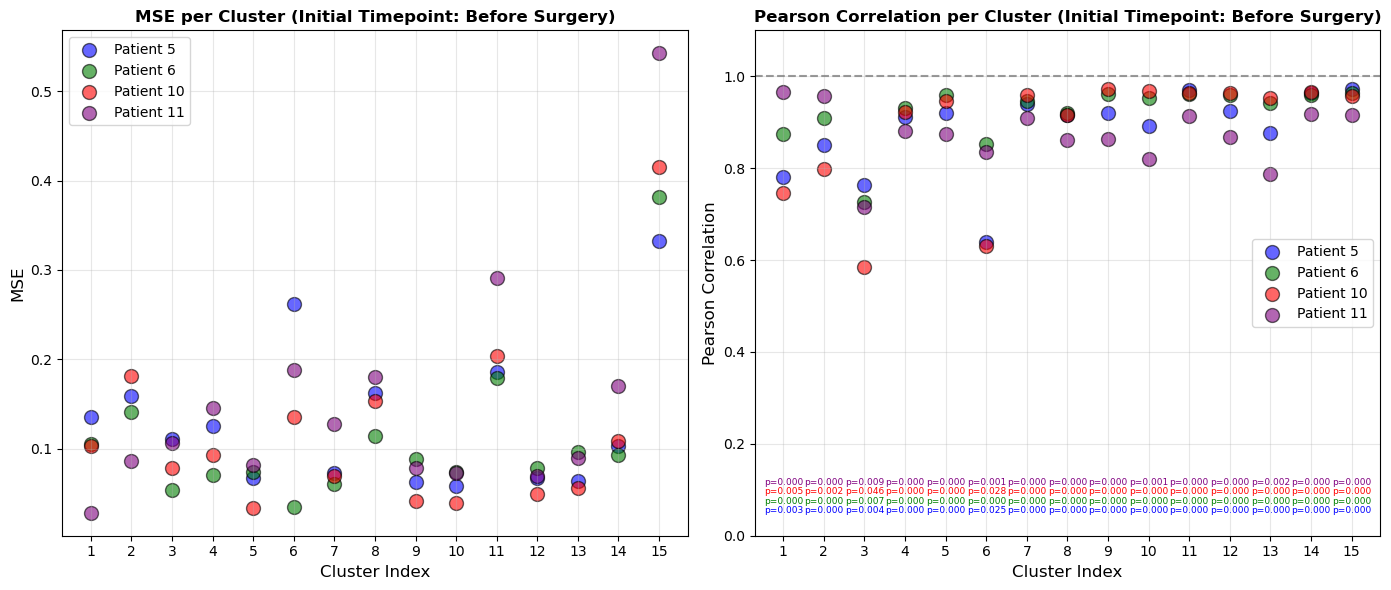

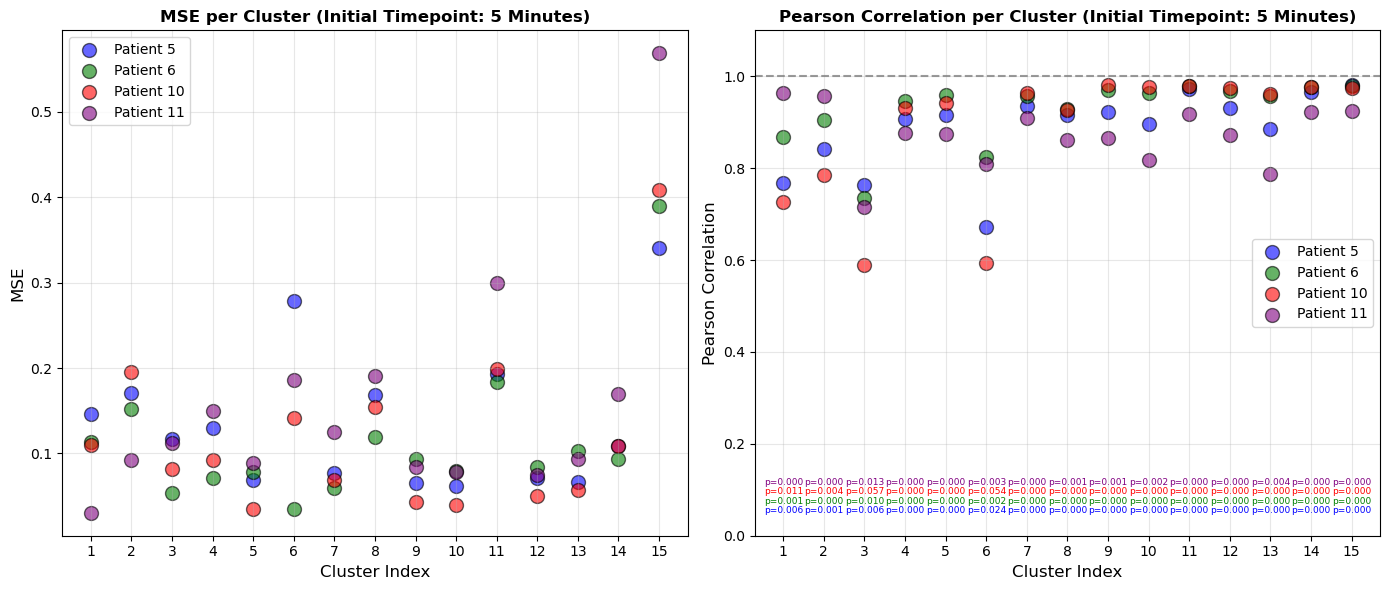

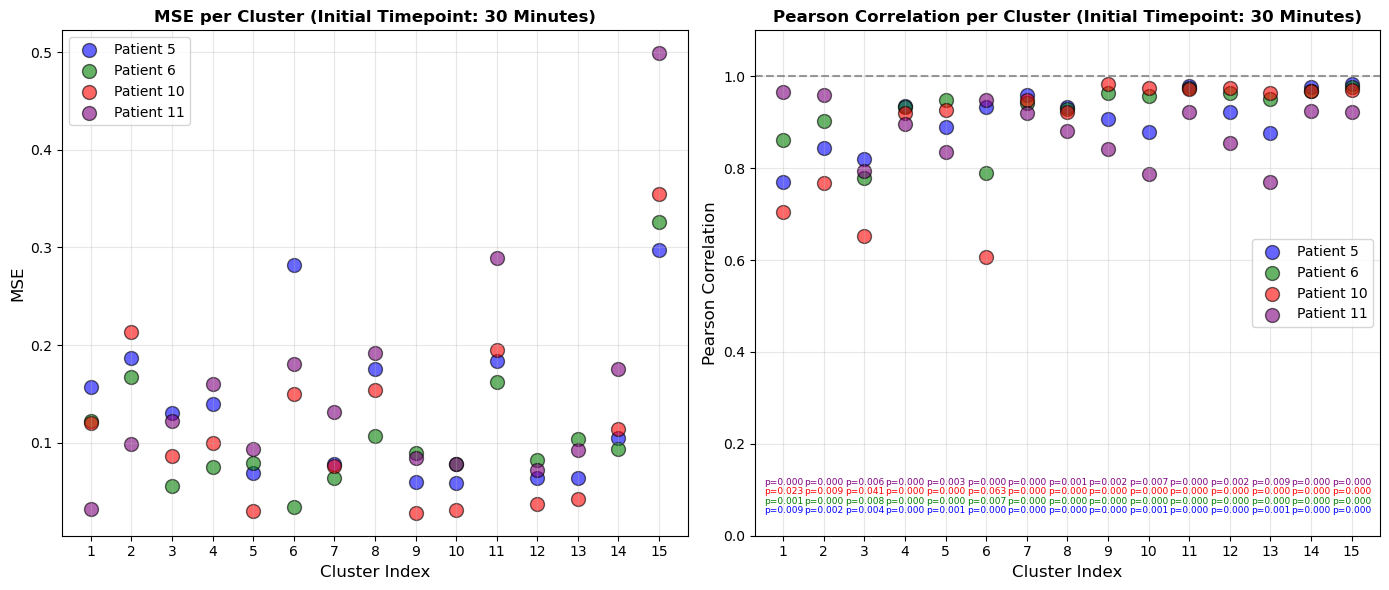

In [70]:

num_timepoints = 13
timepoint_values = np.arange(0, num_timepoints)

# Store MSE, Pearson correlation, and p-values for each patient
mse_values = {}
pearson_values = {}
pvalue_values = {}

# Define colors for different patients (ensure enough unique colors)
patient_colors = ['blue', 'green', 'red', 'purple']

# Loop through each initial timepoint
for initial_timepoint in initial_timepoints:
    mse_clusters = []
    pearson_clusters = []
    pvalue_clusters = []
    patient_labels = []
    
    future_timepoints = np.arange(initial_timepoint + 1, num_timepoints)  # Future predictions
    
    for idx, patient_id in enumerate(test_patients):
        data1 = stored_data[patient_id]
        data = data1[initial_timepoint]['data']

        original_mean1 = mean_data[patient_id]
        original_mean = np.array(original_mean1)[:, future_timepoints]  # (num_clusters, future_timepoints)

        mean_values = np.array(data["mean"])
        predicted_mean = mean_values[:, :len(future_timepoints)]

        mse_per_cluster = np.mean((original_mean - predicted_mean) ** 2, axis=1)
        mse_clusters.append(mse_per_cluster)
        
        # Pearson r and p-value per cluster
        pearson_r_per_cluster = []
        pval_per_cluster = []
        for cl in range(original_mean.shape[0]):
            r_val, p_val = pearsonr(original_mean[cl], predicted_mean[cl])
            pearson_r_per_cluster.append(r_val)
            pval_per_cluster.append(p_val)

        pearson_clusters.append(pearson_r_per_cluster)
        pvalue_clusters.append(pval_per_cluster)

        patient_labels.append(f"Patient {patient_id}")

    mse_clusters = np.array(mse_clusters)        # Shape: (num_patients, num_clusters)
    pearson_clusters = np.array(pearson_clusters)
    pvalue_clusters = np.array(pvalue_clusters)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # MSE Scatter Plot
    for idx, patient_id in enumerate(test_patients):
        axes[0].scatter(range(15), mse_clusters[idx], color=patient_colors[idx], label=f"Patient {patient_id}", s=100, alpha=0.6, edgecolors='black')

    axes[0].set_title(f"MSE per Cluster (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Cluster Index", fontsize=12)
    axes[0].set_ylabel("MSE", fontsize=12)
    axes[0].set_xticks(range(15))
    axes[0].set_xticklabels(range(1, 16))
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Pearson Scatter Plot
    for idx, patient_id in enumerate(test_patients):
        axes[1].scatter(range(15), pearson_clusters[idx], color=patient_colors[idx], label=f"Patient {patient_id}", s=100, alpha=0.6, edgecolors='black')
        for cl in range(15):
            p_val = pvalue_clusters[idx][cl]
            axes[1].text(cl, 0.05 + 0.02 * idx, f"p={p_val:.3f}", ha='center', fontsize=6.5, color=patient_colors[idx])

    axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.8)
    axes[1].set_title(f"Pearson Correlation per Cluster (Initial Timepoint: {timepoint_names[initial_timepoint]})", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Cluster Index", fontsize=12)
    axes[1].set_ylabel("Pearson Correlation", fontsize=12)
    axes[1].set_xticks(range(15))
    axes[1].set_xticklabels(range(1, 16))
    axes[1].set_ylim(0, 1.1)
    axes[1].legend(loc='center right')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"MSE_Pearson_pval_Clusters_initial_timepoint_{timepoint_names[initial_timepoint]}.jpeg", dpi=600)
    plt.show()


In [71]:


# # Set up distinct markers for each patient
# patient_markers = ['o', 's', '^', 'X']  # extend as needed

# # Generate a colormap for clusters
# cmap = plt.cm.get_cmap('tab20', num_clusters)

# plt.figure(figsize=(10, 6))

# for pid_idx, patient_id in enumerate(test_patients):
#     for cl in range(num_clusters):
#         r_val = pearson_clusters[pid_idx][cl]
#         p_val = pvalue_clusters[pid_idx][cl]
#         log_p = -np.log10(p_val + 1e-10)  # add epsilon to avoid log(0)

#         plt.scatter(log_p, r_val,
#                     color=cmap(cl),               # color by cluster
#                     marker=patient_markers[pid_idx % len(patient_markers)],  # shape by patient
#                     edgecolors='black',
#                     s=100,
#                     label=f"P{patient_id}_C{cl+1}" if pid_idx == 0 else "")  # label only once to avoid clutter

# # Legend for clusters
# import matplotlib.patches as mpatches
# cluster_patches = [mpatches.Patch(color=cmap(i), label=f'Cluster {i+1}') for i in range(num_clusters)]
# plt.legend(handles=cluster_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Clusters", fontsize=9)

# # Legend for patients
# from matplotlib.lines import Line2D
# patient_handles = [Line2D([0], [0], marker=patient_markers[i], color='w',
#                           label=f'Patient {test_patients[i]}',
#                           markerfacecolor='gray', markeredgecolor='black', markersize=10)
#                    for i in range(len(test_patients))]
# plt.legend(handles=patient_handles + cluster_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")

# # Axes and title
# plt.xlabel('-log10(p-value)', fontsize=12)
# plt.ylabel('Pearson Correlation (r)', fontsize=12)
# plt.title(f"Correlation vs Significance (Initial TP: {timepoint_names[initial_timepoint]})", fontsize=13)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f"logp_r_scatter_initialTP_{timepoint_names[initial_timepoint]}.jpeg", dpi=600)
# plt.show()


In [72]:
# ================================================================================================
# Effect of variation of gene expression values on the liver volume
# ================================================================================================

# Construct patient and cluster labels to filter mean and std data for the specific patient and timepoint
patient_id = 5
patient_label = f"Patient_{patient_id}"

timepoint = 0 # Before surgery 

# Load mean data
mean_data_path = 'input_data_mean.csv'
df_mean_data = pd.read_csv(mean_data_path)

# Load standard deviation data
std_data_path = 'input_data_std.csv'
df_std_data = pd.read_csv(std_data_path)

# Filter the data to get only rows that match the specified patient
patient_mean_data = df_mean_data[df_mean_data['Patient'] == patient_label]
patient_std_data = df_std_data[df_std_data['Patient'] == patient_label]

# Extract mean and std data vectors for the specified timepoints across all clusters
mean_data = patient_mean_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)
std_data = patient_std_data.iloc[:, 2:].values  # Exclude first two columns (Patient, Cluster)

# Access the relevant data for the current patient and timepoint
gene_data = mean_data[:, timepoint]  # shape: (num_clusters,)

# Convert to torch tensor and add batch dimension (shape becomes [1, num_clusters])
gene_tensor = torch.tensor(gene_data, dtype=torch.float32).unsqueeze(0)

# Plot original vs predicted values
gene_data, predicted_output_np, true_output_np = original_vs_predicted(
    model=model,
    mean_data=gene_tensor,  # use torch tensor here
    output_data_np=output_data_np,
    patient_id=patient_id,
    patient_ids_tensor_np=patient_ids_tensor_np,
    timepoint=timepoint
)

# Use the last predicted values as initial values for the mathematical model
initial_values = predicted_output_np.tolist()

# Solve ODE using MATLAB
next_timepoint_data = calculate_time_series_data(patient_id, timepoint, initial_values)

# Ensure next_timepoint_data is a NumPy array
next_timepoint_data = np.array(next_timepoint_data)

# 3 month data is chosen to see the effect as a normal liver regains its mass in 3 months
# Extract the relevant column from the MATLAB matrix
column_data = next_timepoint_data[:, -3] # get timepoint 3rd last data which is 3 months data

Q1 = column_data[-3]
P1 = column_data[-2]
R1 = column_data[-1]
predicted_liver_vol = Q1 + 2*P1 + 1.5*R1


true_math_model_data = output_data_np[patient_id, :, -3]
Q2 = true_math_model_data[-3]
P2 = true_math_model_data[-2]
R2 = true_math_model_data[-1]
true_liver_vol = Q2 + 2*P2 + 1.5*R2

print(f"True liver volume fraction after 3 months: ", np.array(true_liver_vol))
print(f"Predicted liver volume fraction after 3 months: ", predicted_liver_vol)


True liver volume fraction after 3 months:  0.79054976
Predicted liver volume fraction after 3 months:  0.7893650980540072


In [73]:
def get_liver_volume(model, gene_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np):
    # Predict from model
    _, predicted_output_np, _ = original_vs_predicted(
        model=model,
        mean_data=gene_tensor,
        output_data_np=output_data_np,
        patient_id=patient_id,
        patient_ids_tensor_np=patient_ids_tensor_np,
        timepoint=timepoint
    )
    
    # Use predicted values as initial conditions for the model
    initial_values = predicted_output_np.tolist()
    next_timepoint_data = calculate_time_series_data(patient_id, timepoint, initial_values)
    next_timepoint_data = np.array(next_timepoint_data)
    
    column_data = next_timepoint_data[:, -3]  # 3rd last timepoint = 3 month
    Q = column_data[-3]
    P = column_data[-2]
    R = column_data[-1]
    predicted_liver_vol = Q + 2 * P + 1.5 * R
    return predicted_liver_vol

# Original liver volume (true)
true_math_model_data = output_data_np[patient_id, :, -3]
Q2 = true_math_model_data[-3]
P2 = true_math_model_data[-2]
R2 = true_math_model_data[-1]
true_liver_vol = Q2 + 2 * P2 + 1.5 * R2

# Original gene tensor
original_tensor = torch.tensor(gene_data, dtype=torch.float32).unsqueeze(0)

# Altered gene tensors
tensor_plus_10 = (gene_data * 1.1)
tensor_minus_10 = (gene_data * 0.9)

plus_tensor = torch.tensor(tensor_plus_10, dtype=torch.float32).unsqueeze(0)
minus_tensor = torch.tensor(tensor_minus_10, dtype=torch.float32).unsqueeze(0)

# Run predictions
original_pred = get_liver_volume(model, original_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)
plus_10_pred = get_liver_volume(model, plus_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)
minus_10_pred = get_liver_volume(model, minus_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)

# Print comparison
print(f"\nTrue liver volume fraction after 3 months: {true_liver_vol:.4f}")
print(f"Predicted (original gene data): {original_pred:.4f}")
print(f"Predicted (+10% gene expression): {plus_10_pred:.4f}")
print(f"Predicted (−10% gene expression): {minus_10_pred:.4f}")


/tmp/ipykernel_3194658/429158092.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  original_tensor = torch.tensor(gene_data, dtype=torch.float32).unsqueeze(0)
/tmp/ipykernel_3194658/429158092.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plus_tensor = torch.tensor(tensor_plus_10, dtype=torch.float32).unsqueeze(0)
/tmp/ipykernel_3194658/429158092.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minus_tensor = torch.tensor(tensor_minus_10, dtype=torch.float32).unsqueeze(0)



True liver volume fraction after 3 months: 0.7905
Predicted (original gene data): 0.7894
Predicted (+10% gene expression): 0.7897
Predicted (−10% gene expression): 0.7891


In [74]:
# Generate scaled versions
plus_10_tensor = gene_data * 1.1
minus_10_tensor = gene_data * 0.9
plus_20_tensor = gene_data * 1.2
minus_20_tensor = gene_data * 0.8
plus_30_tensor = gene_data * 1.3
minus_30_tensor = gene_data * 0.7
original_tensor = gene_data.clone()

# Run predictions
original_pred = get_liver_volume(model, original_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)
plus_10_pred = get_liver_volume(model, plus_10_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)
minus_10_pred = get_liver_volume(model, minus_10_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)
plus_20_pred = get_liver_volume(model, plus_20_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)
minus_20_pred = get_liver_volume(model, minus_20_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)
plus_30_pred = get_liver_volume(model, plus_30_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)
minus_30_pred = get_liver_volume(model, minus_30_tensor, patient_id, timepoint, output_data_np, patient_ids_tensor_np)

# Print comparison
print(f"\nTrue liver volume fraction after 3 months: {true_liver_vol:.4f}")
print(f"Predicted (original gene data):         {original_pred:.4f}")
print(f"Predicted (+10% gene expression):       {plus_10_pred:.4f}")
print(f"Predicted (−10% gene expression):       {minus_10_pred:.4f}")
print(f"Predicted (+20% gene expression):       {plus_20_pred:.4f}")
print(f"Predicted (−20% gene expression):       {minus_20_pred:.4f}")
print(f"Predicted (+30% gene expression):       {plus_30_pred:.4f}")
print(f"Predicted (−30% gene expression):       {minus_30_pred:.4f}")


True liver volume fraction after 3 months: 0.7905
Predicted (original gene data):         0.7894
Predicted (+10% gene expression):       0.7897
Predicted (−10% gene expression):       0.7891
Predicted (+20% gene expression):       0.7899
Predicted (−20% gene expression):       0.7889
Predicted (+30% gene expression):       0.7900
Predicted (−30% gene expression):       0.7889


In [76]:
import matplotlib.cm as cm

percent_changes = list(range(-100, 101, 10))  # From -100% to +100%

cluster_effects = {}

plt.figure(figsize=(10, 6))

# Get 15 distinct colors from a colormap
cmap = plt.colormaps.get_cmap('tab20')  # 'tab20' has at least 15 distinct colors
colors = cmap(np.linspace(0, 1, num_clusters))

# Loop through clusters and plot
for cluster_idx in range(num_clusters):
    predicted_volumes = []

    for pct in percent_changes:
        # Clone and modify only the current cluster
        modified_gene_data = gene_data.clone().detach()
        factor = 1 + (pct / 100.0)
        modified_gene_data[0, 0, cluster_idx] *= factor

        # Predict liver volume
        pred_vol = get_liver_volume(
            model,
            modified_gene_data,
            patient_id,
            timepoint,
            output_data_np,
            patient_ids_tensor_np
        )
        predicted_volumes.append(pred_vol)

    # Save and plot with a unique color
    cluster_effects[cluster_idx] = predicted_volumes
    plt.plot(
        percent_changes,
        predicted_volumes,
        marker='o',
        label=f'Cluster {cluster_idx + 1}',
        color=colors[cluster_idx]
    )

# Reference lines
plt.axhline(true_liver_vol, color='r', linestyle='--', label='True Liver Volume')
original_pred = cluster_effects[0][percent_changes.index(0)]  # original prediction
plt.axhline(original_pred, color='g', linestyle=':', label='Predicted (original genes)')

# Final touches
plt.title("Effect of Individual Gene Cluster Perturbation on Liver Volume")
plt.xlabel("Gene Expression Change (%)")
plt.ylabel("Predicted Liver Volume Fraction")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
test_patients = [5, 6, 10, 11]
timepoints = [0, 1, 2]

percent_changes = list(range(-100, 101, 10))  # From -100% to +100%

# Load mean and std data once
mean_data_path = 'input_data_mean.csv'
std_data_path = 'input_data_std.csv'
df_mean_data = pd.read_csv(mean_data_path)
df_std_data = pd.read_csv(std_data_path)

for patient_id in test_patients:
    patient_label = f"Patient_{patient_id}"

    # Filter patient-specific data
    patient_mean_data = df_mean_data[df_mean_data['Patient'] == patient_label]
    patient_std_data = df_std_data[df_std_data['Patient'] == patient_label]

    # Extract mean and std data vectors
    mean_data = patient_mean_data.iloc[:, 2:].values  # shape: (num_clusters, num_timepoints)
    std_data = patient_std_data.iloc[:, 2:].values

    for timepoint in timepoints:
        gene_data = mean_data[:, timepoint]  # shape: (num_clusters,)
        gene_tensor = torch.tensor(gene_data, dtype=torch.float32).unsqueeze(0)

        # True liver volume from ground truth
        true_math_model_data = output_data_np[patient_id, :, -3]
        Q2, P2, R2 = true_math_model_data[-3], true_math_model_data[-2], true_math_model_data[-1]
        true_liver_vol = Q2 + 2 * P2 + 1.5 * R2

        cluster_effects = {}

        fig, ax = plt.subplots(figsize=(10, 6))

        # Loop through clusters
        for cluster_idx in range(num_clusters):
            predicted_volumes = []

            for pct in percent_changes:
                # Modify only current cluster
                modified_gene_data = gene_tensor.clone().detach()
                factor = 1 + (pct / 100.0)
                modified_gene_data[0, cluster_idx] *= factor

                pred_vol = get_liver_volume(
                    model,
                    modified_gene_data,
                    patient_id,
                    timepoint,
                    output_data_np,
                    patient_ids_tensor_np
                )
                predicted_volumes.append(pred_vol)

            cluster_effects[cluster_idx] = predicted_volumes
            ax.plot(
                percent_changes,
                predicted_volumes,
                marker='o',
                label=f'Cluster {cluster_idx + 1}',
                color=colors[cluster_idx]
            )

        # Reference lines
        ax.axhline(true_liver_vol, color='r', linestyle='--', label='True Liver Volume', linewidth=2)
        original_pred = cluster_effects[0][percent_changes.index(0)]
        ax.axhline(original_pred, color='g', linestyle=':', label='Predicted (original genes)', linewidth=2)

        # Bold and enlarge font styling
        # ax.set_title(
        #     f"Effect of Gene Cluster Perturbation on Liver Volume\nPatient {patient_id}, Timepoint {timepoint_names[timepoint]}",
        #     fontsize=16, fontweight='bold'
        # )
        ax.set_title(
            f"Patient {patient_id}, Timepoint: {timepoint_names[timepoint]}",
            fontsize=16, fontweight='bold'
        )
        ax.set_xlabel("Gene Expression Change (%)", fontsize=14, fontweight='bold')
        ax.set_ylabel("Predicted Liver Volume Fraction", fontsize=14, fontweight='bold')

        ax.tick_params(axis='both', labelsize=12)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

        ax.grid(True)
        ax.legend(
            bbox_to_anchor=(1.05, 0.5),
            loc='center left',
            fontsize='small',
            title="Clusters",
            title_fontsize=11
        )

        # Save figure
        filename = f"liver_volume_effect_patient_{patient_id}_timepoint_{timepoint_names[timepoint]}.png"
        plt.tight_layout()
        plt.savefig(filename, dpi=600)
        plt.close()


In [ ]:
# import joblib

# # Save each patient's data from stored_data
# for patient_id in [5, 6, 10, 11]:
#     filename = f"stored_data_{patient_id}.pkl"
#     joblib.dump(stored_data[patient_id], filename)
